## Comparison of Maximum CDI to Maximum MMI

Intensity, or the expression / damage level of the earthquake on the surface, is traditionally reported as a Modified Mercalli Intensity (MMI) rating, 0 - 12. In the last 20 years, a new method, using crowd sourced internet reported effects and damage estimates, was established by the USGS.  

This project first compared the crowdsourced intensity values, known as "community decimal intensity (CDI), with the MMI, and found that CDI typically evaluates an earthquake's intensity slightly lower than MMI, but that with the inclusion of additional factors of region and depth, and using the number of CDI reports per quake as a quality measure, that CDI can be reasonably used in place of MMI. This is fortunate, as it is cheap and easy to collect, and therefore CDI estimates exist for 3-4 times the earthquakes that have professionally assigned MMI measurements.

In [1]:
# Import the usual libraries for data organization, mathematics, and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
# Read in the cleaned earthquake data
# This data was cleaned and exploratory data analysis done in the note book  Capstone-EDA.ipynb

df = pd.read_csv('./datasets/clean_quakes_v2.csv')
df.shape

(114498, 32)

In [3]:
df.head(2)

,id,long,lat,depth,alert,cdi,code,detail,dmin,felt,...,time,title,tsunami,type,types,tz,updated,url,magDecade,year
0,nc1022389,-121.8735,36.593,4.946,0.0,NaN,1022389,https://earthquake.usgs.gov/fdsnws/event/1/que...,0.03694,NaN,...,1974-12-30 13:28:16.830,M 3.4 - Central California,False,earthquake,"focal-mechanism,nearby-cities,origin,phase-data",NaN,2016-12-14 18:02:44.940,https://earthquake.usgs.gov/earthquakes/eventp...,3,1974
1,nc1022388,-121.4645,36.929,3.946,0.0,NaN,1022388,https://earthquake.usgs.gov/fdsnws/event/1/que...,0.04144,NaN,...,1974-12-30 09:46:54.820,M 3.0 - Central California,False,earthquake,"nearby-cities,origin,phase-data",NaN,2016-12-14 18:02:33.974,https://earthquake.usgs.gov/earthquakes/eventp...,2,1974


### Extract the factors needed for the model



In [4]:

dfm = df[df['mmi'].notnull()][['id','lat', 'long', 'depth', 'mag', 'mmi', 'cdi', 'alert', \
                              'felt', 'time', 'net', 'type',  'gap', 'magDecade', 'year']]

In [5]:
dfm.shape

(2955, 15)

In [6]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2955 entries, 1148 to 114485
Data columns (total 15 columns):
id           2955 non-null object
lat          2955 non-null float64
long         2955 non-null float64
depth        2955 non-null float64
mag          2955 non-null float64
mmi          2955 non-null float64
cdi          2107 non-null float64
alert        2955 non-null float64
felt         2107 non-null float64
time         2955 non-null object
net          2955 non-null object
type         2955 non-null object
gap          2744 non-null float64
magDecade    2955 non-null int64
year         2955 non-null int64
dtypes: float64(9), int64(2), object(4)
memory usage: 369.4+ KB


In [7]:
# We must have the CDI data, so drop reacords where it is missing. 
# There are a some records missing in other fields as well, 
# this drops all rows with any value missing

dfm = dfm.dropna()

In [8]:
dfm.shape

(2009, 15)

In [9]:
# CDI values that were created with fewer than 5 crowd sourced reports are less reliable, 
# so we filter those out also, leaving us with 1606 records

dfm[dfm['felt'] >= 5].shape

(1606, 15)

### Examine the distributions of the magnitude and intensity

This highlights one of the difficulties with this dataset, that we hae many more earthquakes at lower magnitude and intensith than we have at higher magnitude.   While this is good for those living in earthquake zones, it makes it harder to model, as the abundant data at lower values disproportionately affects the regression line fit.

To handle this, I employed a weighted bootstrap, to resample the data with emphasis on retaining many more of the higher magnitude qua5kes.  A dataset of the same size was built, but sampling the original (with replacement) and keeping the sample if a randomly generated number was higher than a clip threshold for each magnitude bin.  The sample was retained 25% of the time for magnitudes less than 3, while only 5% of the time for quakes with magnitude  between 3 and 4.  All samples of quakes with magnitude of 7 or higher were kept, as were 90% of samples with magnitude between 6 and 7.  As seen below, this produced a dataset with a more uniform distribution of magnitude, a measure of the energy released during an earthquake.  

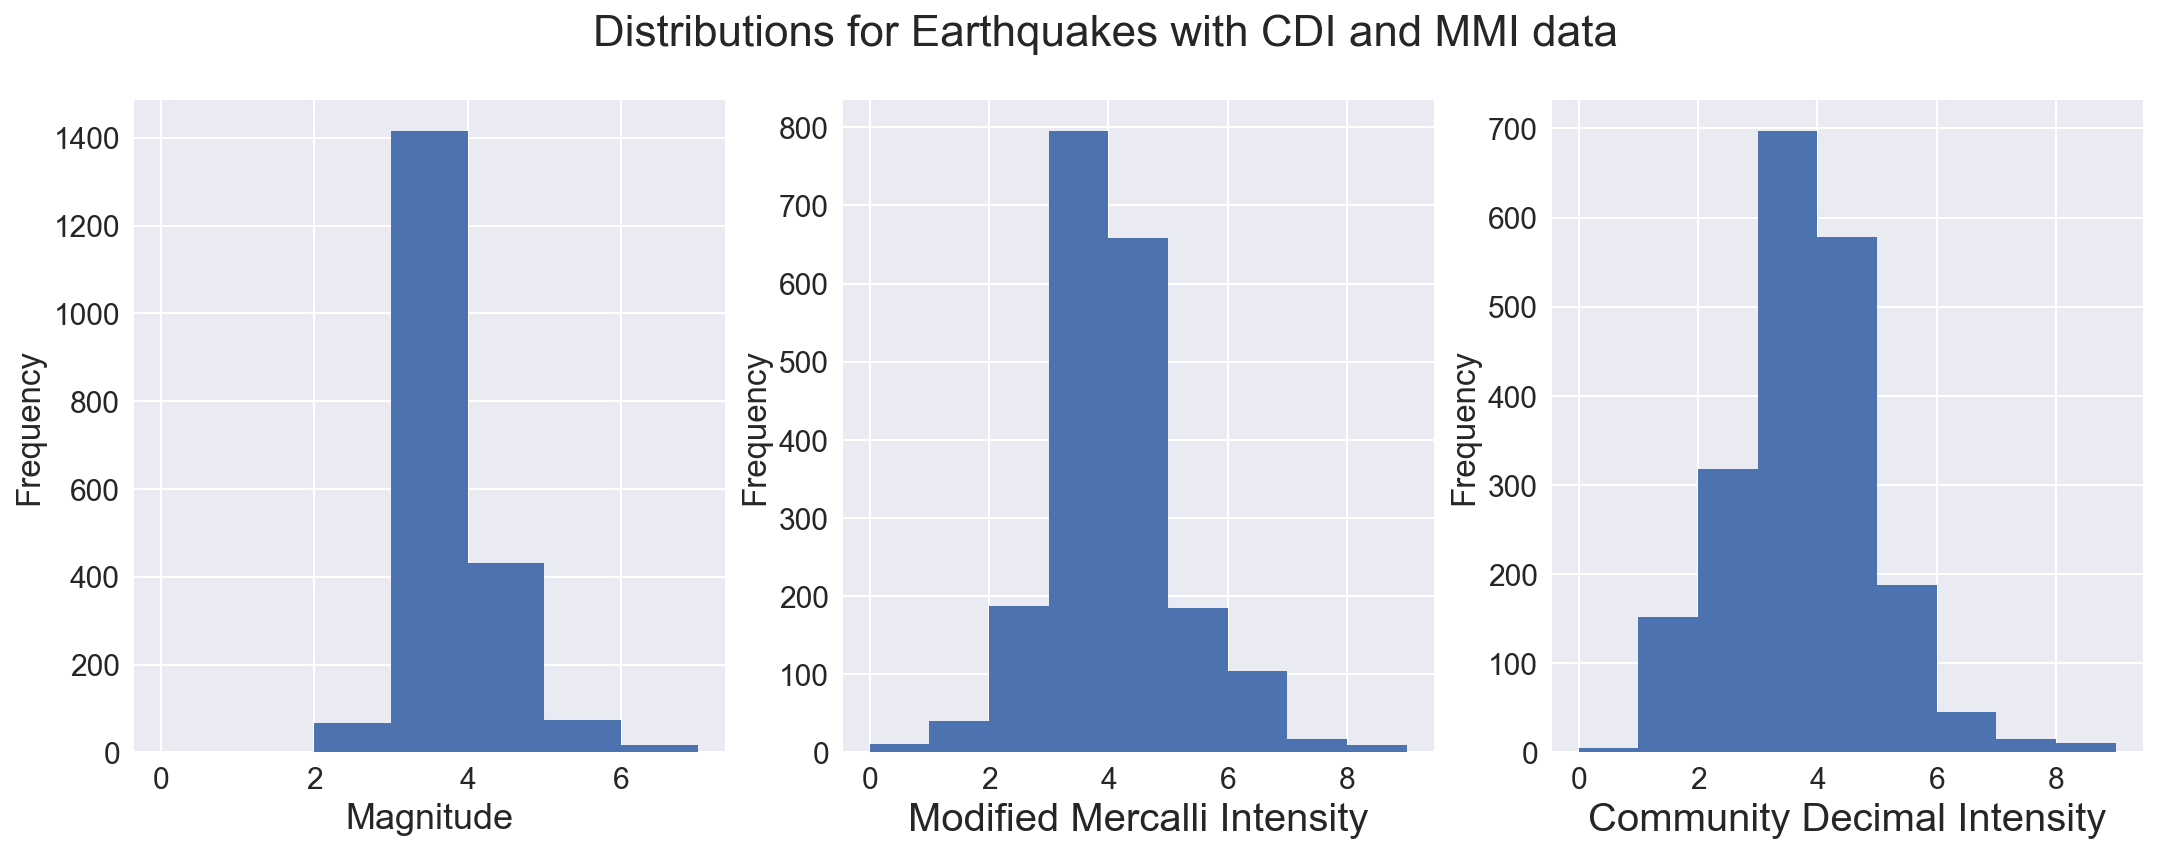

In [10]:
sns.set(font_scale=1.5)
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle("Distributions for Earthquakes with CDI and MMI data", fontsize=22)

dfm['mag'].plot(kind='hist', bins=7, range=(0,7), ax=axs[0])
dfm['mmi'].plot(kind='hist', bins=9, range=(0,9), ax=axs[1])
dfm['cdi'].plot(kind='hist', bins=9, range=(0,9), ax=axs[2])
axs[0].set_xlabel('Magnitude', fontsize=18)
axs[1].set_xlabel('Modified Mercalli Intensity', fontsize=20)
axs[2].set_xlabel('Community Decimal Intensity', fontsize=20)
axs[0].locator_params(numticks=9)


In [11]:
# bootstrap with filter to obtain samples more equally distributed across earthquake magnitude

from random import random

dfmw = pd.DataFrame()

idx=0
while (len(dfmw) < len(dfm)) and (idx<=20000):
           
    prn = random()
#     sample = pd.DataFrame(dfm.iloc[idx]).T
    sample = dfm.iloc[idx]
   
    if sample['mag'].item() <= 3:
        weight = 0.75
    elif sample['mag'].item() <= 4:
        weight = 0.95
    elif sample['mag'].item() <= 5:
        weight = 0.8
    elif sample['mag'].item() <= 6:
        weight = 0.1
    else:
        weight = 0
        
    if prn >= weight:
        dfmw = dfmw.append(sample, ignore_index=True)
        
    idx += 1    
    if idx == len(dfm):
        idx = 0
    
dfmw.shape




(2009, 15)

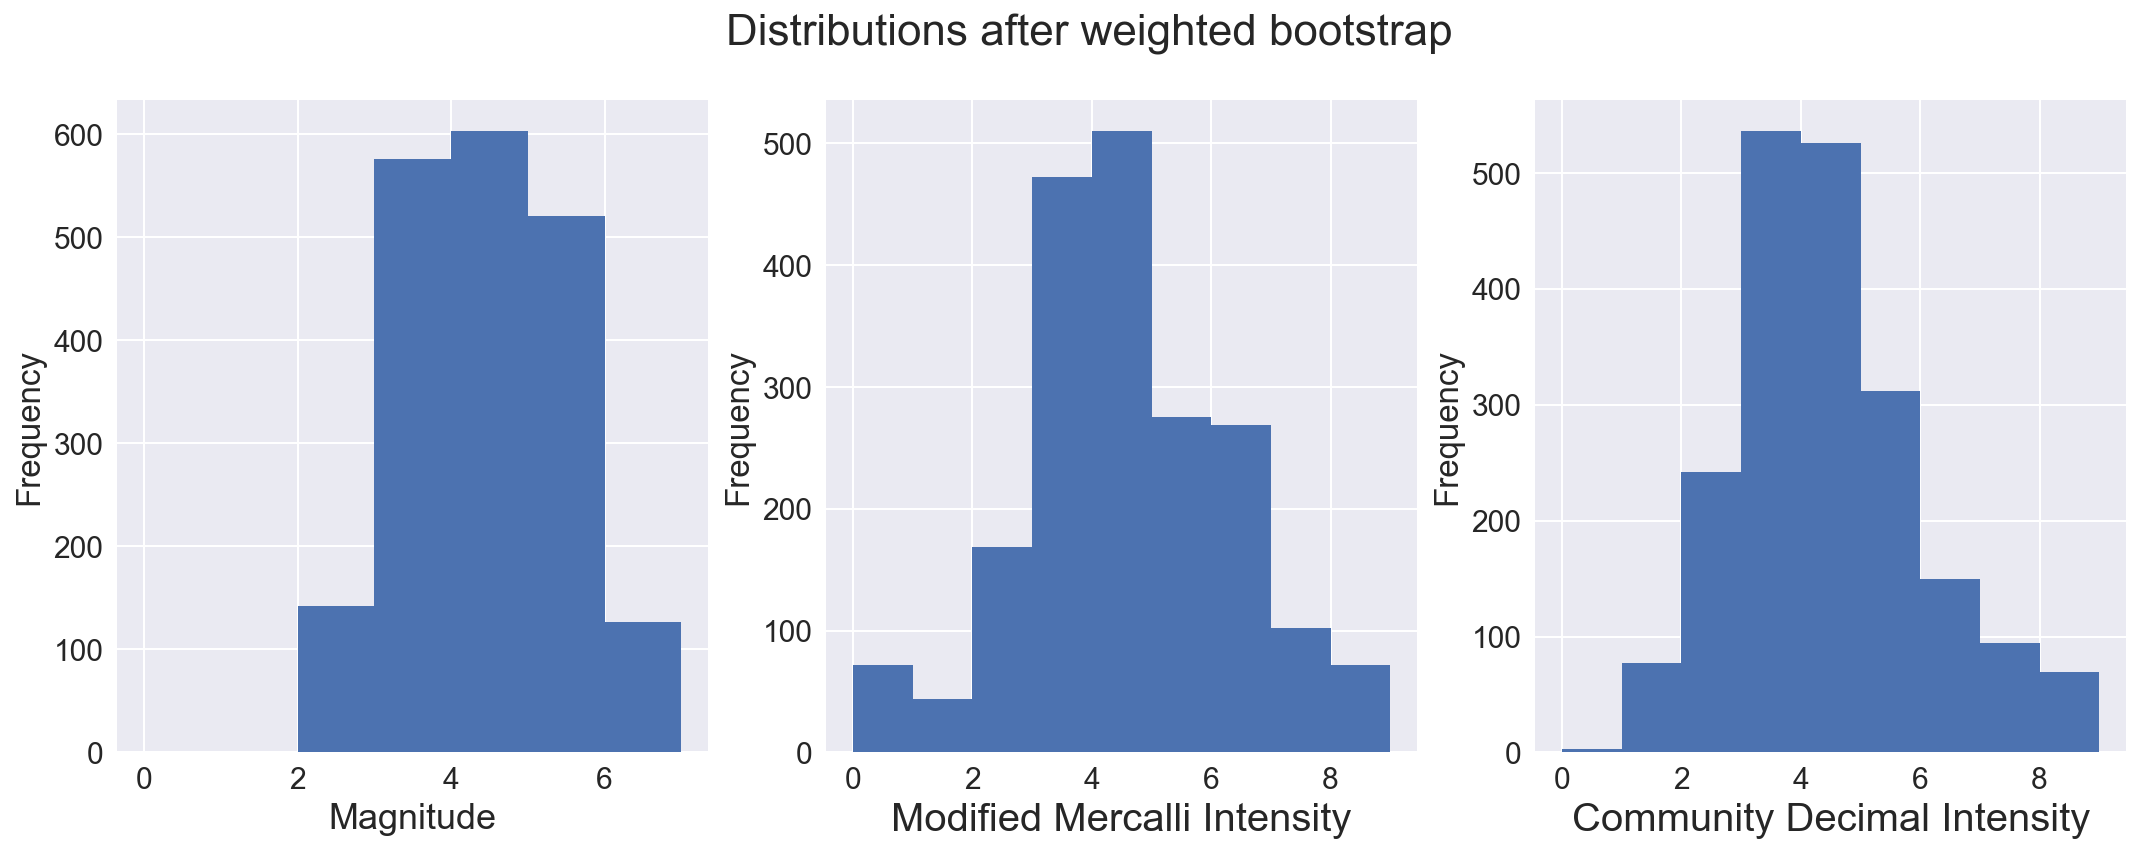

In [12]:
# Plot distribution of magnitude, Modified Mercalli Intensity and Community Decimal Intensity

sns.set(font_scale=1.5)
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle("Distributions after weighted bootstrap", fontsize=22)

dfmw['mag'].plot(kind='hist', bins=7, range=(0,7), ax=axs[0])
dfmw['mmi'].plot(kind='hist', bins=9, range=(0,9), ax=axs[1])
dfmw['cdi'].plot(kind='hist', bins=9, range=(0,9), ax=axs[2])
axs[0].set_xlabel('Magnitude', fontsize=18)
axs[1].set_xlabel('Modified Mercalli Intensity', fontsize=20)
axs[2].set_xlabel('Community Decimal Intensity', fontsize=20)
axs[0].locator_params(numticks=9)


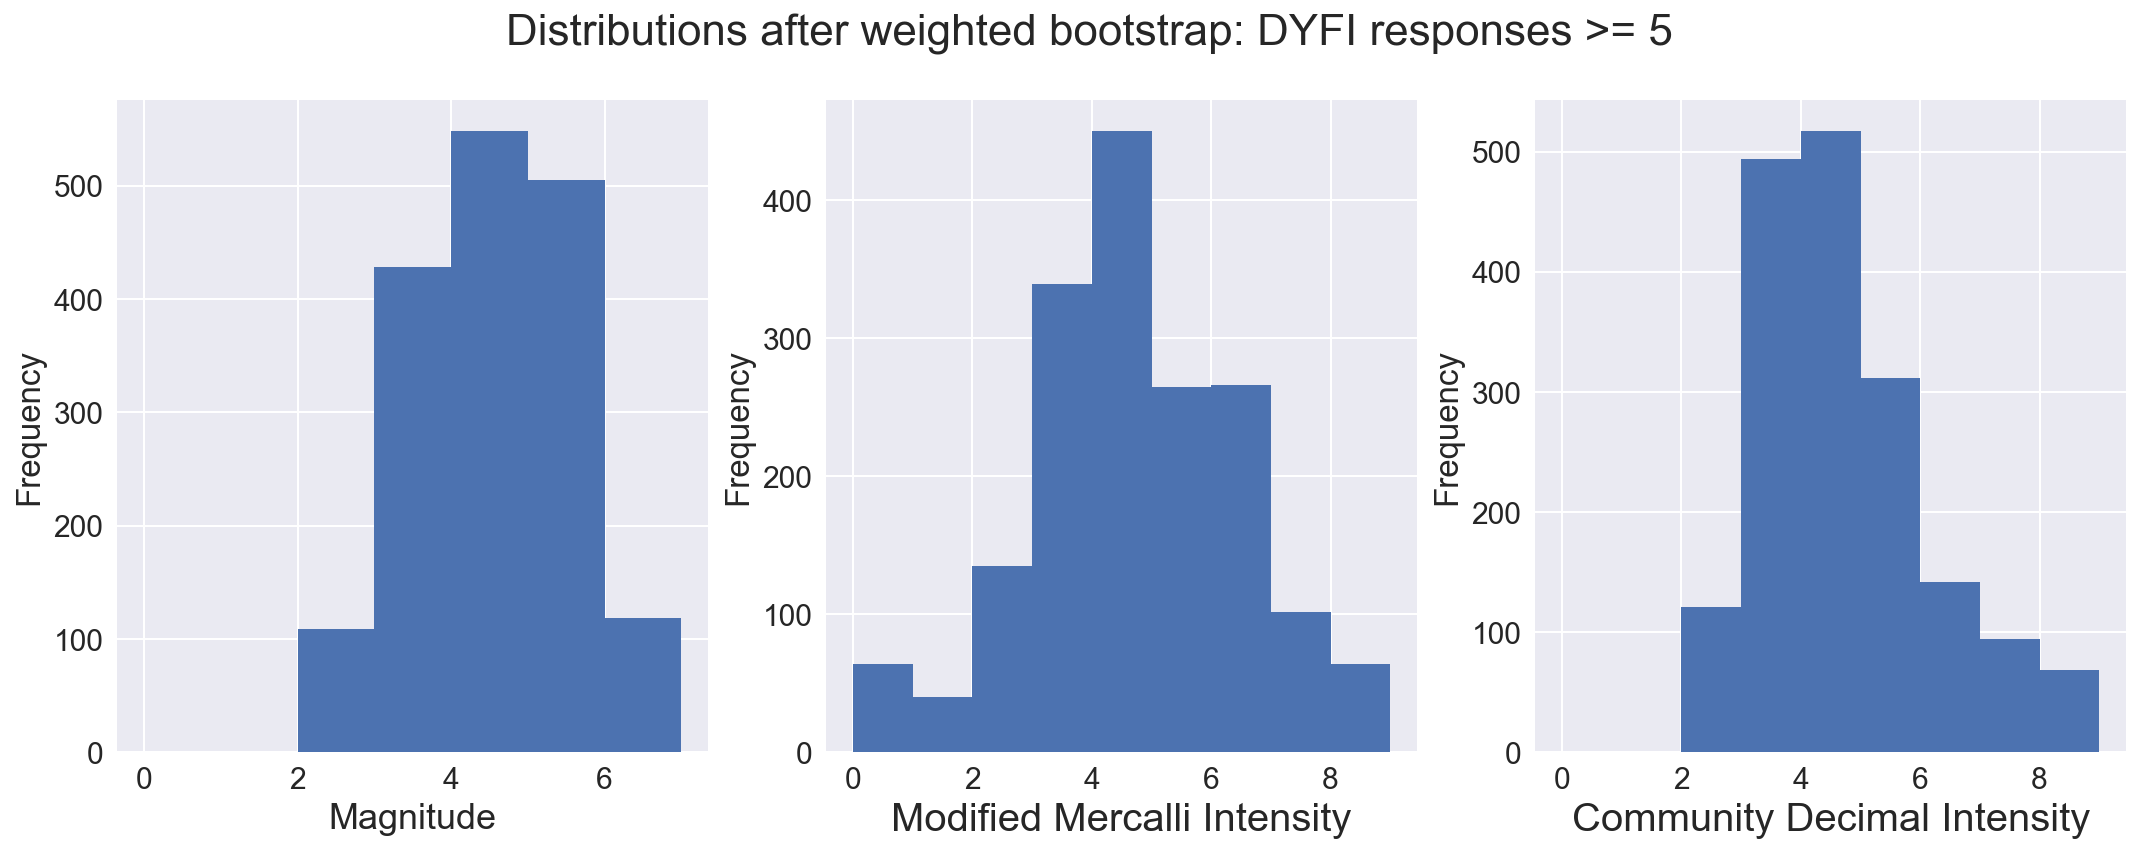

In [13]:
# Further restrict the dataset to those samples where 5 or more crowdsourced reports were used to calculate the CDI.

sns.set(font_scale=1.5)
fig, axs = plt.subplots(ncols=3, figsize=(18,6))
fig.suptitle("Distributions after weighted bootstrap: DYFI responses >= 5", fontsize=22)

dfmw[dfmw['felt'] >= 5]['mag'].plot(kind='hist', bins=7, range=(0,7), ax=axs[0])
dfmw[dfmw['felt'] >= 5]['mmi'].plot(kind='hist', bins=9, range=(0,9), ax=axs[1])
dfmw[dfmw['felt'] >= 5]['cdi'].plot(kind='hist', bins=9, range=(0,9), ax=axs[2])
axs[0].set_xlabel('Magnitude', fontsize=18)
axs[1].set_xlabel('Modified Mercalli Intensity', fontsize=20)
axs[2].set_xlabel('Community Decimal Intensity', fontsize=20)
axs[0].locator_params(numticks=9)


In [14]:
dfmw.head()

,alert,cdi,depth,felt,gap,id,lat,long,mag,magDecade,mmi,net,time,type,year
0,0.0,8.9,8.950,1141.0,123.4,ci3347678,34.416000,-118.370000,6.6,6.0,8.6,ci,1971-02-09 09:00:41.920,earthquake,1971.0
1,0.0,8.3,15.000,75.0,168.0,ci3352060,32.667333,-115.359167,6.4,6.0,9.5,ci,1979-10-15 19:16:53.910,earthquake,1979.0
2,0.0,8.4,9.578,73.0,137.0,nc1091100,36.231667,-120.312000,6.7,6.0,8.3,nc,1983-05-02 19:42:38.060,earthquake,1983.0
3,0.0,6.8,17.214,2.0,89.0,nc216859,37.036167,-121.879833,6.9,6.0,8.6,nc,1989-10-17 20:04:15.190,earthquake,1989.0
4,0.0,8.6,8.881,859.0,44.4,ci731691,34.061000,-118.079000,5.9,5.0,7.5,ci,1987-10-01 10:42:20.020,earthquake,1987.0


### Graphic view of correlation between MMI and CDI.

Three correlation plots are shown.  
  - The first compares MMI and CDI for each bin,  2-3, 3-4, 4-5 etc.
  - The second divides samples of magnitude below 3 with those samples with magnitude of 6 or greater
  - The third shows the best fit regression line through all data, regardless of magnitude, and shows the distribution of the two intensity measures for the sample set. 
  
In all cases, it can be seen that the crowdsourced Community Decimal Intensity under reports the intensity for larger magnitude quakes as compared to the Modified Mercalli, expertly determined, Intensity.


In [15]:
def set_color(magbin):
    if magbin == 2:
        color = "0000FF"
    elif magbin == 3:
        color = "007FDD"
    elif magbin == 4:
        color = "008E7F"
    elif magbin == 5:
        color = "80E100"        
    elif magbin == 6:
        color = "FFFF00"
    elif magbin == 7:
        color = "FFA000"
    elif magbin == 8:
        color = "FF5A00"
    else: 
        color = "FF0000"  
    
    return color

In [16]:
dfmw['color'] = dfmw['magDecade'].map(lambda x: set_color(x))

In [17]:
# sns.color_palette(palette=['#007FDD', '#008E7F', '#80E100,' '#FFFF00', '#FFA000', '#FF5A00'], n_colors=6, desat=None)

quake_colors = ['#007FDD',  # Q2
                    '#008E7F',  # Q3
                    '#80E100',  # Q4
                    '#FFFF00',  # Q5
                    '#FFA000',  # Q6
                    '#FF5A00',  # Q7
                   ]

quake_colors2 = ['#007FDD',  # Q2 or Q3
                 '#FF5A00',  # Q6 or Q7
                   ]


In [18]:
dfmw_plot1 = dfmw[(dfmw['felt']>=5) & (dfmw['mmi'] != 0)][['mmi', 'cdi', 'felt', 'magDecade']].copy()
dfmw_plot1['          magSize'] = dfmw_plot1['magDecade'].map(lambda x: 0 if x <= 3 else 1 if x >= 6 else np.nan)
dfmw_plot1.columns = ['Modified Mercalli Intensity', 'Community Decimal Intensity', 'felt', 'magDecade', '          magSize' ]


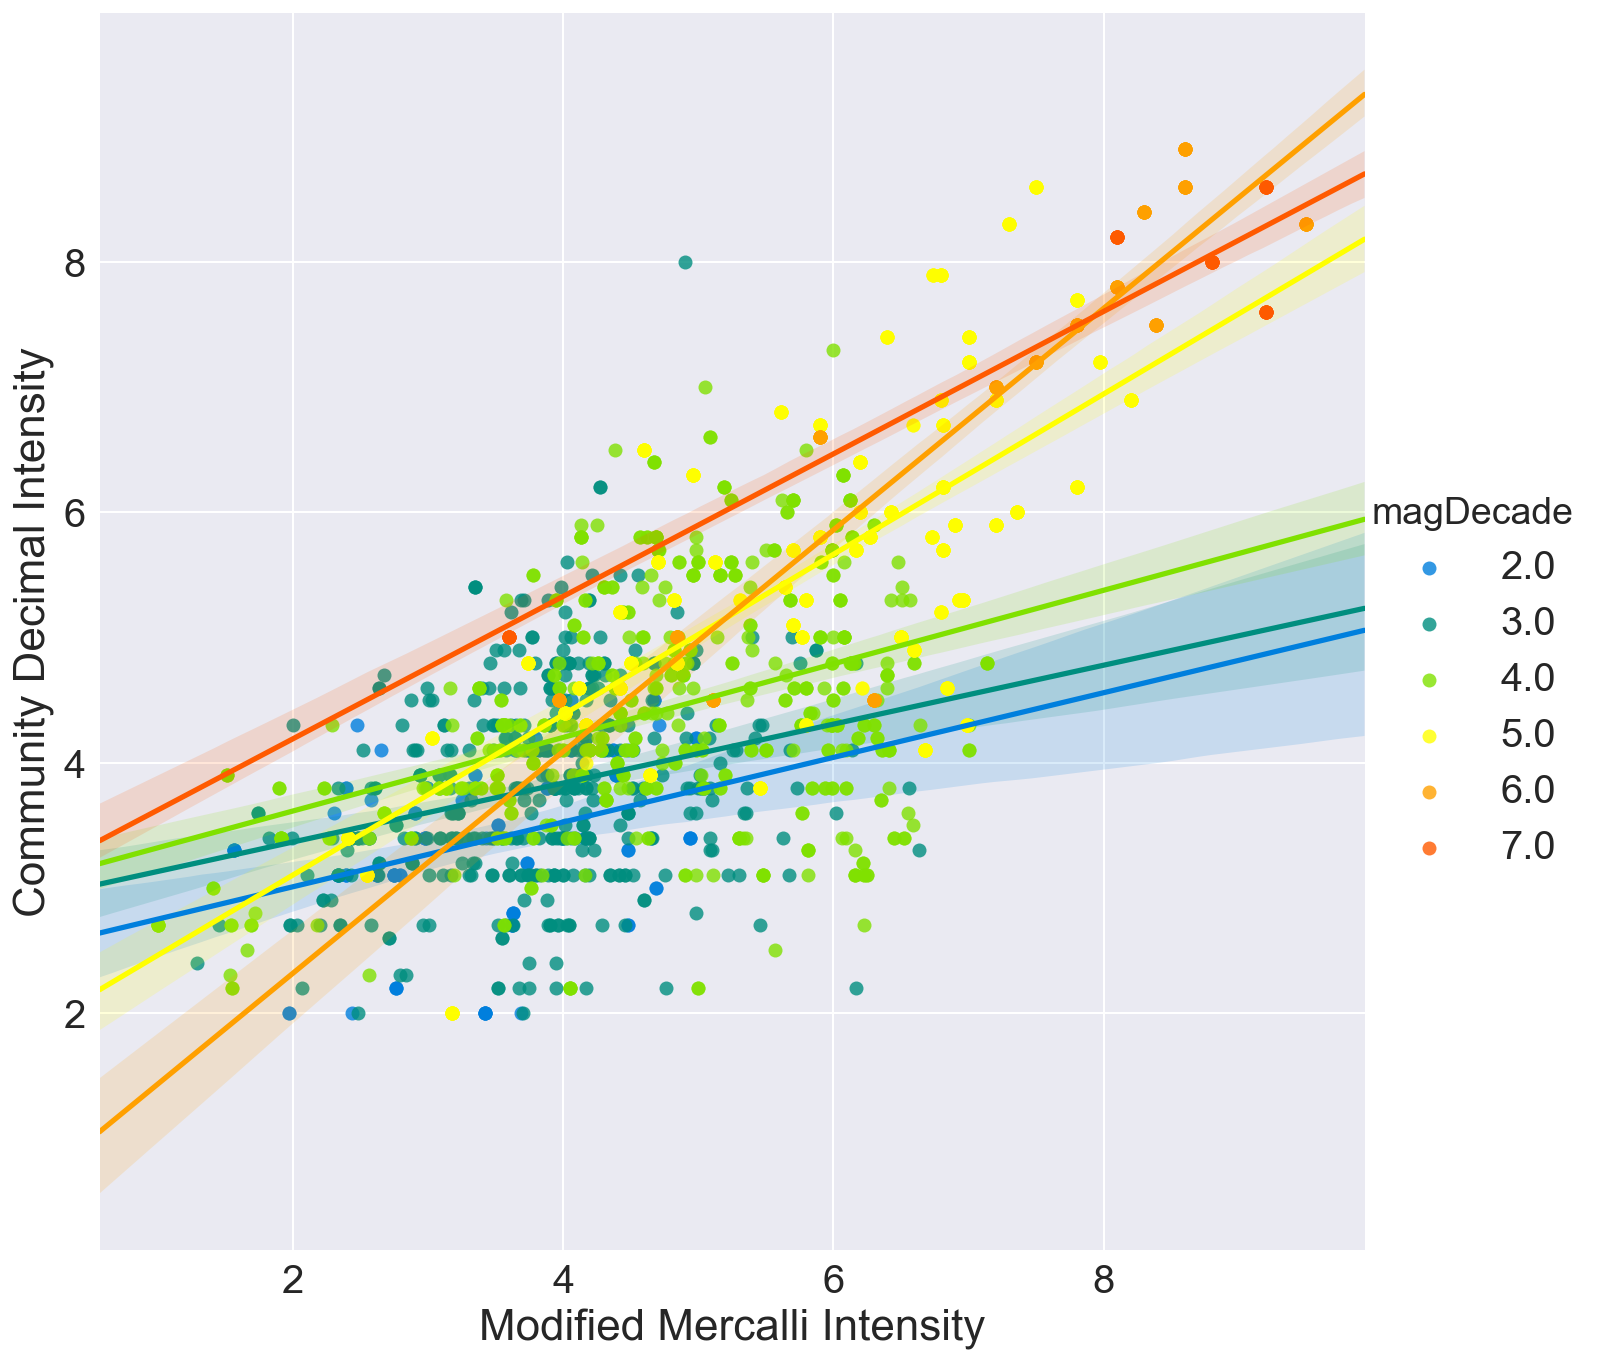

In [19]:
# fig, ax = plt.subplots(figsize=(8,5))
sns.set(font_scale=2)
sns.lmplot('Modified Mercalli Intensity', 'Community Decimal Intensity', \
           data=dfmw_plot1[(dfmw_plot1['felt']>=5)], \
           hue='magDecade', palette=quake_colors, size=10, aspect=1)

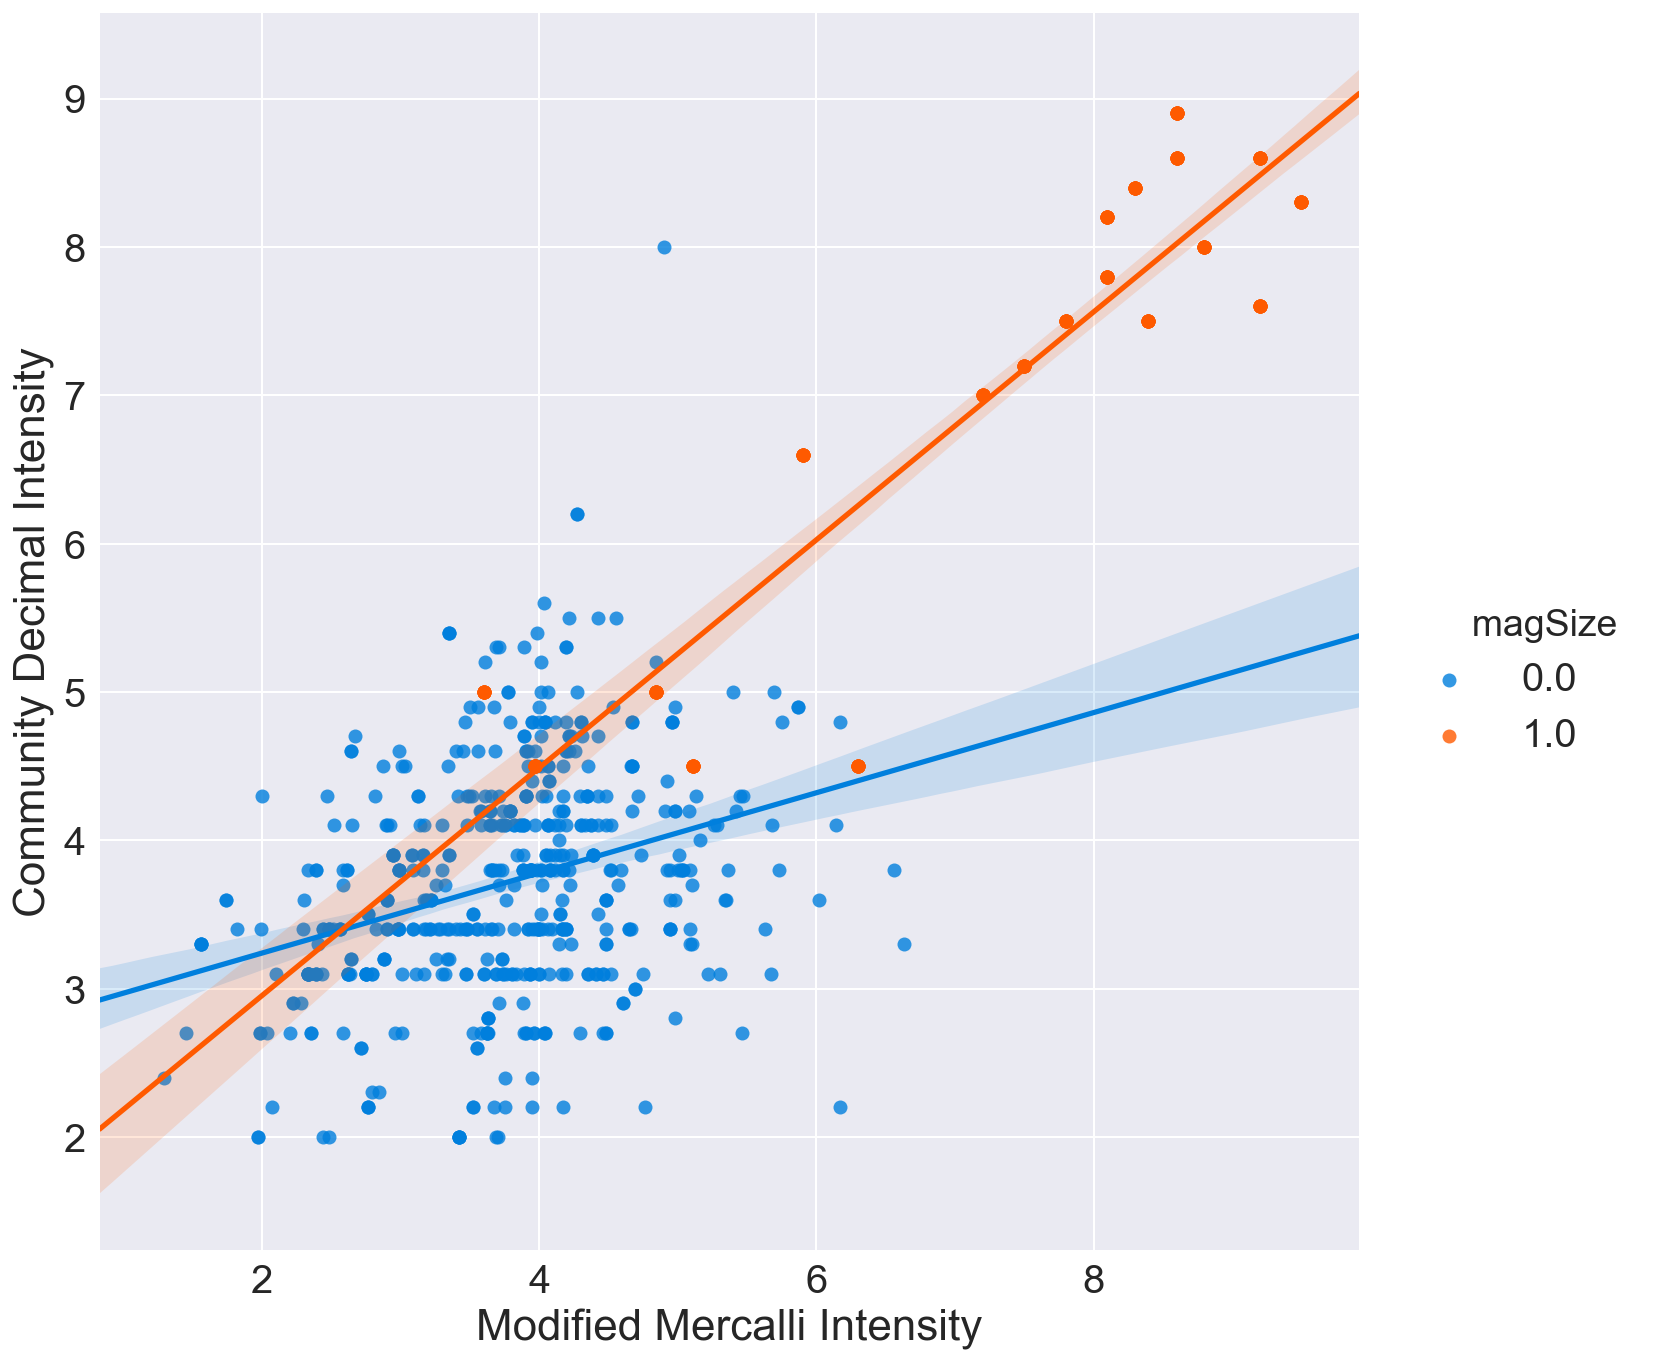

In [20]:

sns.set(font_scale=2)
sns.lmplot('Modified Mercalli Intensity', 'Community Decimal Intensity', \
           data=dfmw_plot1[(dfmw_plot1['felt']>=5) & (dfmw_plot1['          magSize'].notnull())], \
           hue='          magSize', palette=quake_colors2, size=10, aspect=1)

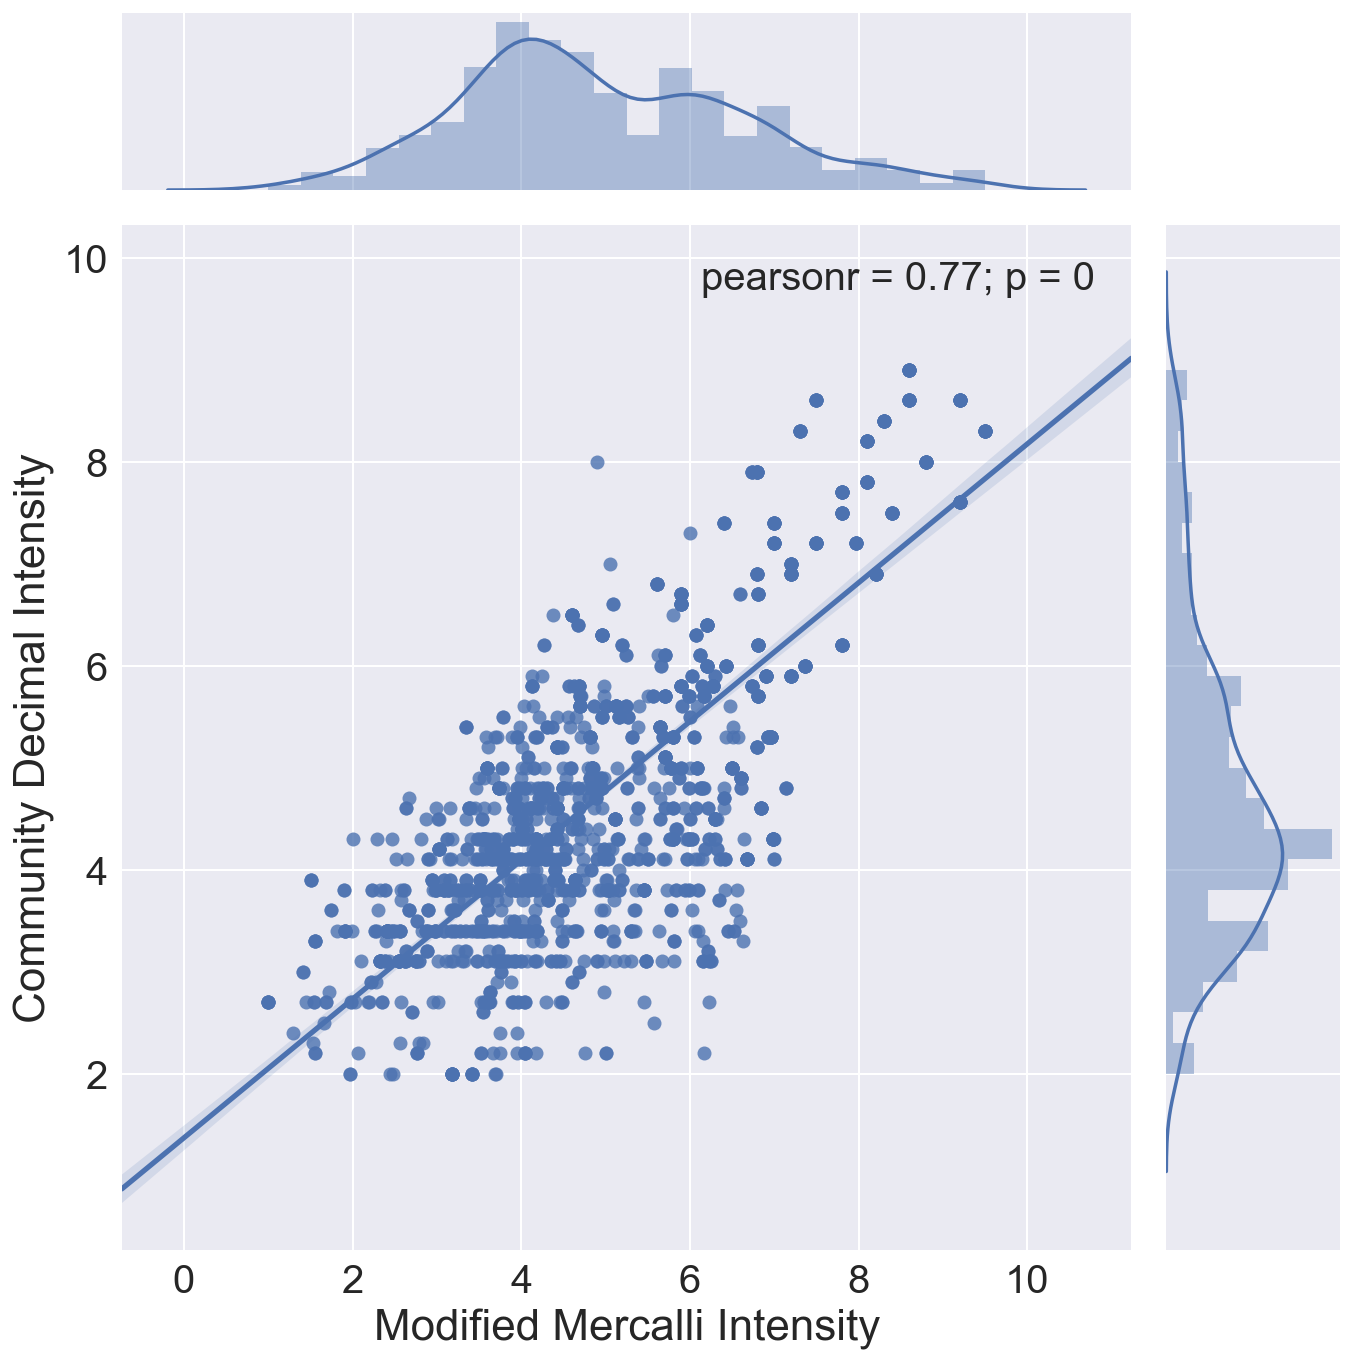

In [21]:
sns.set(font_scale=2)
sns.jointplot('Modified Mercalli Intensity', 'Community Decimal Intensity', \
           data=dfmw_plot1[(dfmw_plot1['felt']>=5)], \
           kind = "reg", size=10)

### Feature Engineering

New factors were created to look more deeply into these relationships
  - samples were binned to the West, Central and Eastern zones of the US
  - factors showing the rounded, integer equivalent intensities were created, as intensity was traditionally reported as integer numbers between 0 and 12.
  - The difference between the intensity, both rounded integer and decimal, was added.
  
This was done both to see if there might be a closer correlation between the integer MMI and CDI values, but also in preparation for classification models to be run, which will predct the integer MMI value from the CDI and other parameters. 

In [22]:
# Feature Engineering 
dfmw['mmi-cdi_difference'] = dfmw['mmi'] - dfmw['cdi']
dfmw['mmi_round'] = dfmw['mmi'].round(0)
dfmw['cdi_round'] = dfmw['cdi'].round(0)
dfmw['diff_rounded'] = dfmw['mmi_round'] - dfmw['cdi_round']
dfmw['EW'] = dfmw['long'].map(lambda x: 'East' if x > -90 else 'Mid' if x > -105 else 'West')

dfmw['cdi_round'] = dfmw['cdi_round'].map(lambda x: int(x))
dfmw['mmi_round'] = dfmw['mmi_round'].map(lambda x: int(x))
dfmw['diff_rounded'] = dfmw['mmi_round'] - dfmw['cdi_round']

In [23]:
dfmw[['mag', 'mmi', 'cdi', 'felt', 'mmi_round', 'cdi_round', 'diff_rounded', 'mmi-cdi_difference' ]].head()

,mag,mmi,cdi,felt,mmi_round,cdi_round,diff_rounded,mmi-cdi_difference
0,6.6,8.6,8.9,1141.0,9,9,0,-0.3
1,6.4,9.5,8.3,75.0,10,8,2,1.2
2,6.7,8.3,8.4,73.0,8,8,0,-0.1
3,6.9,8.6,6.8,2.0,9,7,2,1.8
4,5.9,7.5,8.6,859.0,8,9,-1,-1.1


###### Average Difference,  Regional effects

The mean difference between all MMI and CDI values is only 0.26, but the standard deviation is 1.34, indicating that there is significant variation in the mean difference values.  

There is slightly better MMI / CDI correlation in the Central and Eastern US.  In the East, this might be due to denser crustal material allowing earthquake energy to travel longer distances and increasing the area where higher intensity might be felt.  This was surprising in the central zone, where there is significant expanse of lower density sedimentary basin geology. 

Comparing the integer MMI to the integer CDI using all samples shows the western pattern of CDI underreporting intensity as compared to MMI.  This is unsurprising, as there are many more samples of Western US earthquakes.

In [24]:

print dfmw['mmi-cdi_difference'].mean(), dfmw['mmi-cdi_difference'].std()

0.261632653061 1.34716813151


In [25]:
# Dummy the country regional indicator to separate eastern, central and western quakes
dfmw = pd.get_dummies(dfmw, columns=['EW'], prefix='Z', prefix_sep='_')
dfmw = dfmw.drop('Z_Mid', 1)


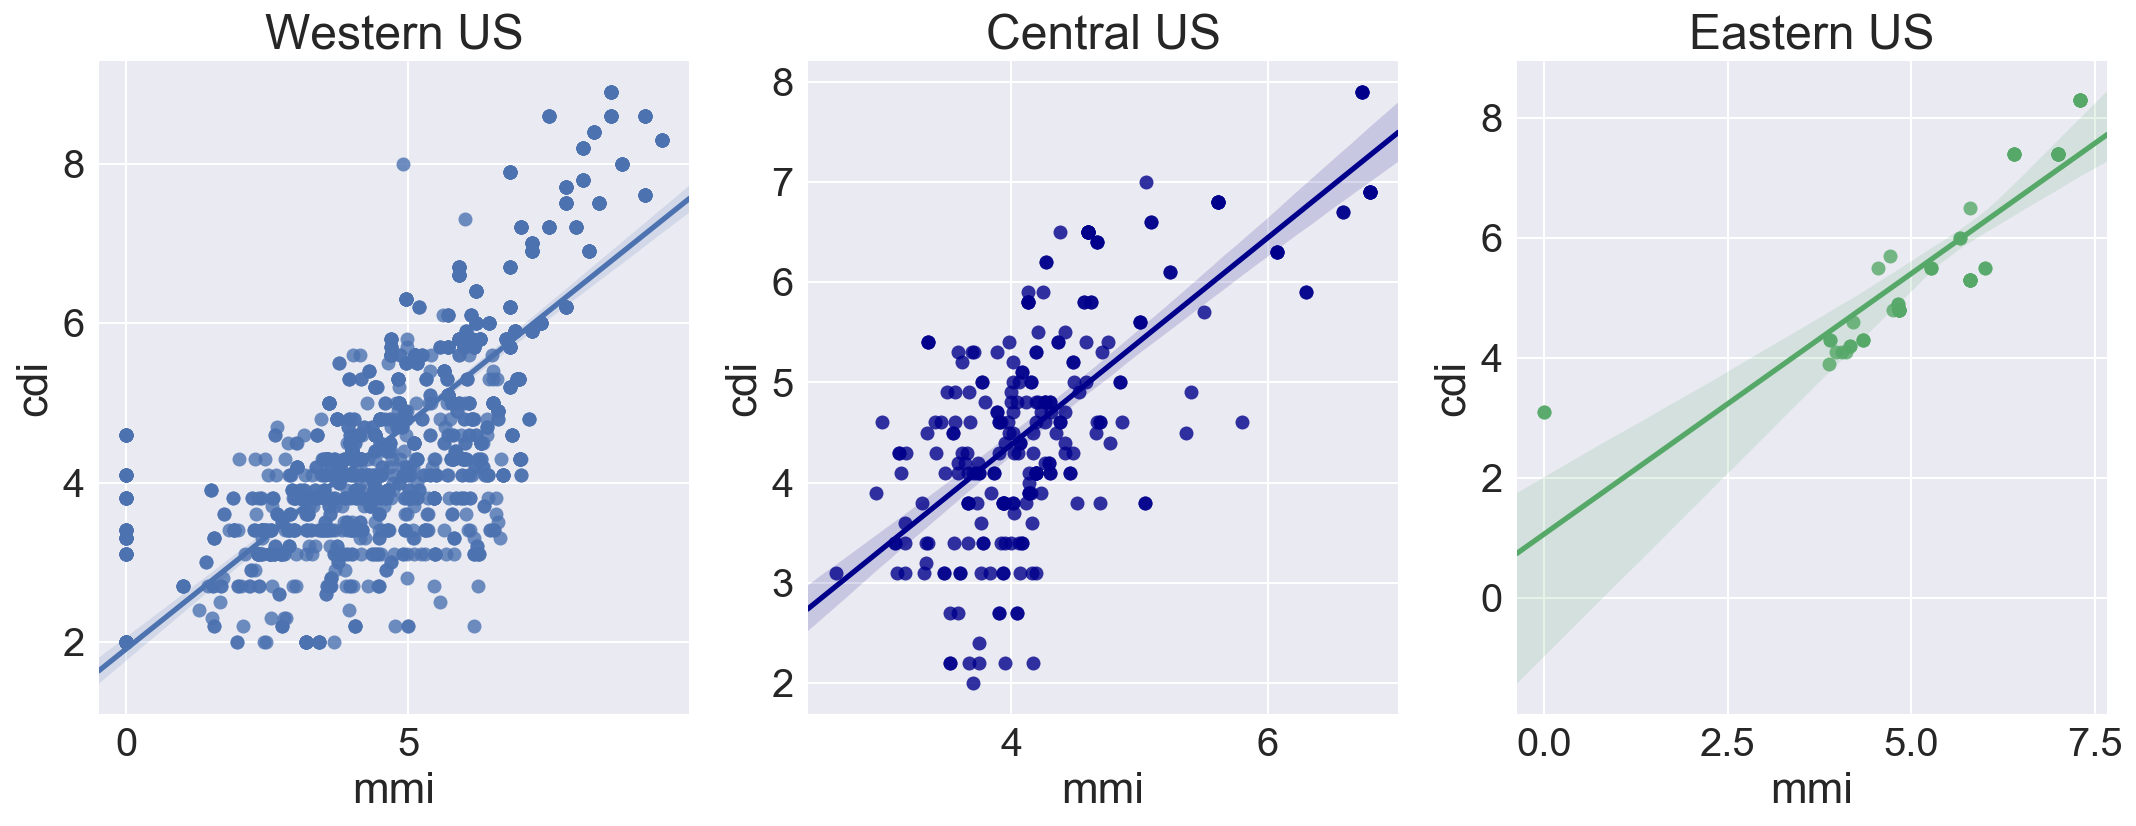

In [26]:
# Plot correlation of mmi and cdi for quakes in Western, Central and Eastern US
fig, axs = plt.subplots(ncols=3, figsize=(18,6))


sns.regplot('mmi', 'cdi', data=dfmw[(dfmw['felt']>=5) & (dfmw['Z_West']) ], ax=axs[0])

sns.regplot('mmi', 'cdi', data=dfmw[(dfmw['felt']>=5) & ~(dfmw['Z_West']) & ~(dfmw['Z_East']) ],\
              ax=axs[1], color='darkblue')

sns.regplot('mmi', 'cdi', data=dfmw[(dfmw['felt']>=5) & (dfmw['Z_East']) ], ax=axs[2])

axs[0].set_title('Western US')
axs[1].set_title('Central US')
axs[2].set_title('Eastern US')



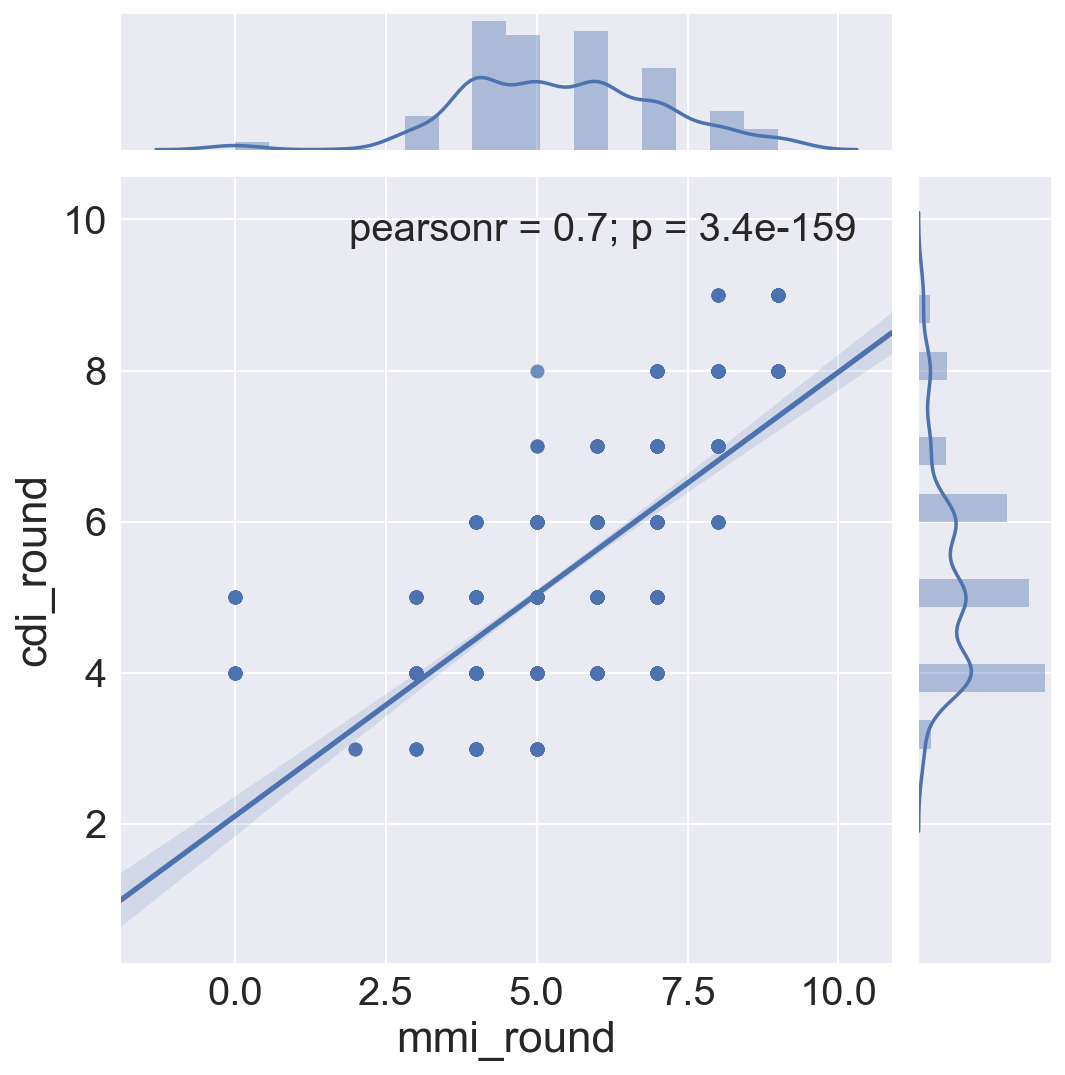

In [27]:
# Look at just the traditional integer intensity scales by rounding the decimal values.   
# The pearson correlation coefficient is not as good as it was when using decimal scale intensities above. 

sns.jointplot('mmi_round', 'cdi_round', data=dfmw[dfmw['felt']>100], kind = "reg", size=8)

## Build Classification Models

I built two classification models to predict MMI from crowd sourced CDI.  If this is possible, then the factors which influnce the difference between the Modified Mercalli Intensity and the slightly lower values from the Community Decimal Intensity. 

The first model uses 
  - depth
  - number of cdi reports
  - zone (western, central, eastern) as factors.

A second model includes the features from the first model, and adds 
  - Quality measures of the magnutide 
    - magnitude calculation type
    - largest azimuthal gap between stations
    - number of reporting stations
    - primary reporting network
  - Quality of CDI assessment
    - number of "Did You Feel It?" reports for each quake
    - time of day of earthquake (this turned out to not provide any coherant influence)
  - Crust1.0 data - a crustal model with thickness and density of crustal layers, developed by researchers at Lawrence Livermore National Lab.  https://igppweb.ucsd.edu/~gabi/crust1.html 

The data dictionary for the USGS Commmon Catalog of Earthquake Data is very helpful in understanding the factors used.  https://earthquake.usgs.gov/data/comcat/data-eventterms.php


### Model 1:  Logistic Regression - 
#### Regularization:  Ridge,  Strength:  C=1

This model uses defalt values for regularization, with no attempt to tune this.  With these few factors and the assumed orthogonality between them, overfitting is not expected to be a problem, but a gridsearch to find best regulariztion parameters will run next after intial model.

In [28]:
# Import the correct libraries for Logistic Regression, either SciKit Learn or StatsModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import statsmodels.api as sm

In [29]:
y = dfmw['mmi_round'].values
X = dfmw[['cdi', 'depth', 'felt', 'Z_East', 'Z_West']]

In [30]:
# MMI Baseline
dfmw['mmi_round'].value_counts(dropna=False)

4     601
5     324
6     306
3     287
7     174
2      93
8      84
0      72
9      48
1      12
10      8
Name: mmi_round, dtype: int64

In [31]:
# MMI Baseline continued
# 4 is the majority class
baseline = 601.0 / len(dfmw['mmi_round'])
baseline

0.29915380786460927

In [32]:
# Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [33]:
# Standardize

# Standardize the data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [34]:
# Logistic Regression instantiation.  Note that penalty and solver are set to the defaults.

# See http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for details

lr = LogisticRegression(penalty="l2", C=1, fit_intercept=True, solver="liblinear")


In [35]:
# Next step is to fit the model
lr.fit(Xs_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
# Diplay the model results and coefficients

# The score, intercept and coefficients 
print "Model Score:", lr.score(Xs_train, y_train)
print "Intercept:", lr.intercept_
print "Coefficients:", lr.coef_

# Also the classes
print "\nPrediction Classes:", lr.classes_


Model Score: 0.408961593172
Intercept: [-3.86133794 -4.91173358 -3.91708595 -2.73073976 -1.20072544 -1.7485775
 -1.95038224 -2.88280747 -5.19729505 -5.63174751 -5.5148582 ]
Coefficients: [[-0.76362037  0.17691095 -0.46196057  0.43072877  0.82841482]
 [-0.68832482  0.24066698 -0.01651672  0.04113787  0.3086479 ]
 [-0.88499784  0.47327597 -0.99748266  0.04503197  0.8913371 ]
 [-1.24884694  0.48956827 -1.6316105  -0.49774772 -0.06869755]
 [-0.44766727 -0.13383711 -1.35610309 -0.22481553 -0.72974785]
 [ 0.23155552 -0.47834206 -0.53117561  0.30258659  0.23398375]
 [ 0.46630384 -0.31665001  0.03611068  0.34075793  0.60171148]
 [ 0.92997209 -0.5696308   0.30887668  0.12386617  0.40835953]
 [ 2.01172045  0.3957158   0.19392966 -0.49752179  0.87401229]
 [ 1.82411242 -0.16394402  0.2103106  -0.4700785   0.68128807]
 [ 1.19159181  0.26658051 -0.82296951 -0.03100784  0.13810488]]

Prediction Classes: [ 0  1  2  3  4  5  6  7  8  9 10]


In [38]:
# The default model accuracy  
print lr.score(Xs_test, y_test)

0.394693200663


In [39]:
# Get predicted values to plot against actuals
predicted = lr.predict(Xs_test)

# Save residuals for future modeling
lr_residuals = y_test - predicted

In [40]:
logreg_test = pd.DataFrame({'y_test' : y_test, 'predicted' : predicted, 'residuals' : lr_residuals})
logreg_test = logreg_test[['y_test', 'predicted', 'residuals']]
# logreg_test = logreg_test[['y', 'predicted']]

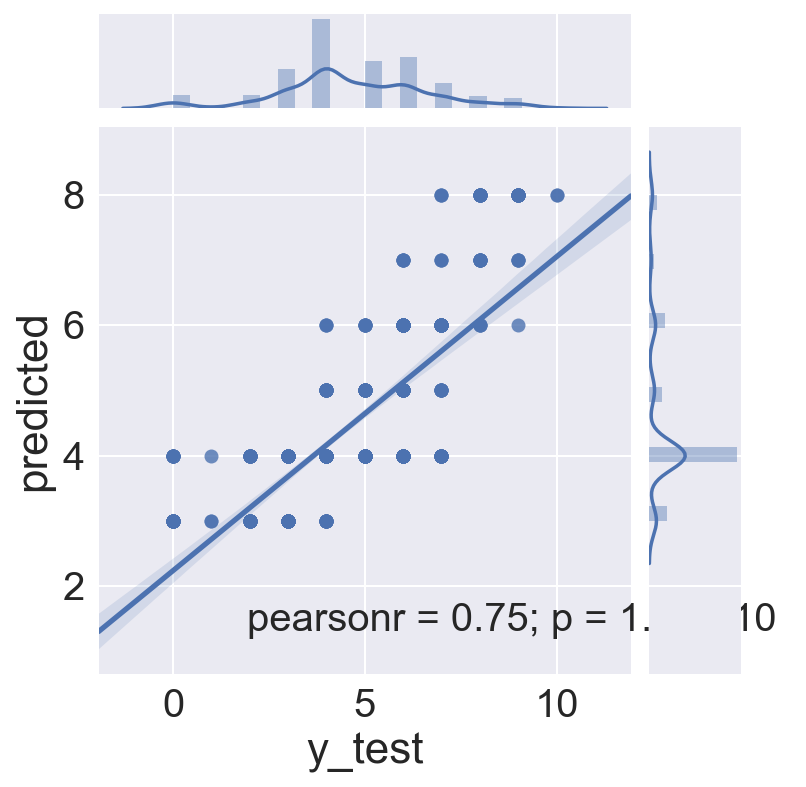

In [41]:
sns.jointplot(x='y_test', y='predicted', data=logreg_test, kind="reg")

In [42]:
logreg_test.head()

,y_test,predicted,residuals
0,3,4,-1
1,8,8,0
2,4,4,0
3,5,4,1
4,8,7,1


### Model 1:  Logistic Regression with GridSearch
#### Determine best regularization strength and method

While it is plausible that all factors in model one are reasonably orthogonal, and that overfitting with few factors is unlikely, I ran a GridSearch just to make sure.   It seems a ridge regularization with bit more strength improves the model.


In [55]:
from sklearn.model_selection import GridSearchCV

# Gridsearch for best C and penalty
gs_params = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,5,100)
}

# Define the GridSearch with CrossValidation and fit the model
lr_gridsearch_m1 = GridSearchCV(LogisticRegression(), gs_params, cv=3, verbose=1, n_jobs=-1)
lr_gridsearch_m1.fit(Xs_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.26186e-05, ...,   7.92483e+04,   1.00000e+05]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [59]:
# best score on the training data:
print "Best Score:", lr_gridsearch_m1.best_score_

# best parameters:
print "Best Parameters:", lr_gridsearch_m1.best_params_

Best Score: 0.421763869132
Best Parameters: {'penalty': 'l1', 'C': 58.57020818056661, 'solver': 'liblinear'}


In [60]:
# assign the best estimator to a variable:
best_lr_m1 = lr_gridsearch_m1.best_estimator_

In [61]:
# Score it on the testing data:
best_lr_m1.score(Xs_test, y_test)

0.40630182421227196

### Number of Samples and Prediction Stability of each Intensity Level
The regression plots above showed varying quality of fit for each magnitude level.  Let's see if that is reflected in the prediction model.   Remember the goal here is to see if CDI (crowd sourced) can be equivalent to MMI (expert assessed) intensity.  In this model we are comparing only the maximum CDI to the maximum MMI for each earthquake.  Thus, we'd like to see a plot with an intercept at 0, and a positive slope 45 degree line, where MMI = CDI at each intensity.  We are predicting MMI, so the class in the table below is the MMI prediction.

What we see instead is intercepts below 0 in all cases, but much closer to 0 for intensities with more samples. Of even more interest is the relationship of CDI to MMI (class).  The model shows that a larger and larger CDI coefficient is required for each increasing level of intensity in order for it to match the corresponding MMI, i.e the CDI reported maximum intensity numbers are generally lower than MMI numbers from 4 onward, and higer than MMI numbers from 3 downward.

Evidence from the initial correlation scatter plots, from the distribution graphs, and now from the logistic regression model all seem to indicate that maximum CDI intensity is reported in a narrower zone than maximum MMI intensity. 

In [93]:
# Examine the relationship of number of samples to intercept and coefficients

for i in range(11):
    for j in range(5):
        coef_T[j][i] = best_lr_m1.coef_[i][j]
        
        
m1_result = pd.DataFrame({'class': best_lr_m1.classes_, 'intercept': best_lr_m1.intercept_, \
              'cdi': coef_T[0], \
              'depth': coef_T[1], \
              'felt': coef_T[2], \
              'Z_East': coef_T[3], \
              'Z_West': coef_T[4], \
              'num_samples': pd.Series(y_train).value_counts().sort_index()})

m1_result = m1_result[['class', 'num_samples', 'intercept', 'cdi', 'depth', 'felt', 'Z_East', 'Z_West']]
m1_result

,class,num_samples,intercept,cdi,depth,felt,Z_East,Z_West
0,0,46,-4.966626,-0.794547,0.188782,-1.677828,1.235309,2.536336
1,1,9,-20.061206,-0.789206,0.354134,-46.191729,0.000000,1.969268
2,2,66,-29.119896,-0.347485,0.552798,-82.894393,0.000000,2.624119
3,3,210,-5.270519,-1.080204,0.499090,-10.230018,-1.125777,-0.030238
4,4,424,-1.270225,-0.432568,-0.132865,-1.632007,-0.220743,-0.731095
5,5,230,-1.764310,0.236552,-0.488268,-0.553843,0.308218,0.239212
6,6,204,-1.970695,0.472895,-0.324443,0.035069,0.351818,0.623618
7,7,123,-2.953208,0.964297,-0.609777,0.312642,0.134098,0.433104
8,8,60,-7.151520,2.504545,0.472238,0.275177,-0.498556,2.926376
9,9,28,-9.669955,3.199057,-0.193623,0.414633,-0.694726,2.806037


In [94]:
# Get predicted values to plot against actuals
gs_predicted_m1 = best_lr_m1.predict(Xs_test)


In [95]:
gs_logreg_test_m1 = pd.DataFrame({'y_test' : y_test, 'predicted' : gs_predicted_m1})
gs_logreg_test_m1 = logreg_test[['y_test', 'predicted']]

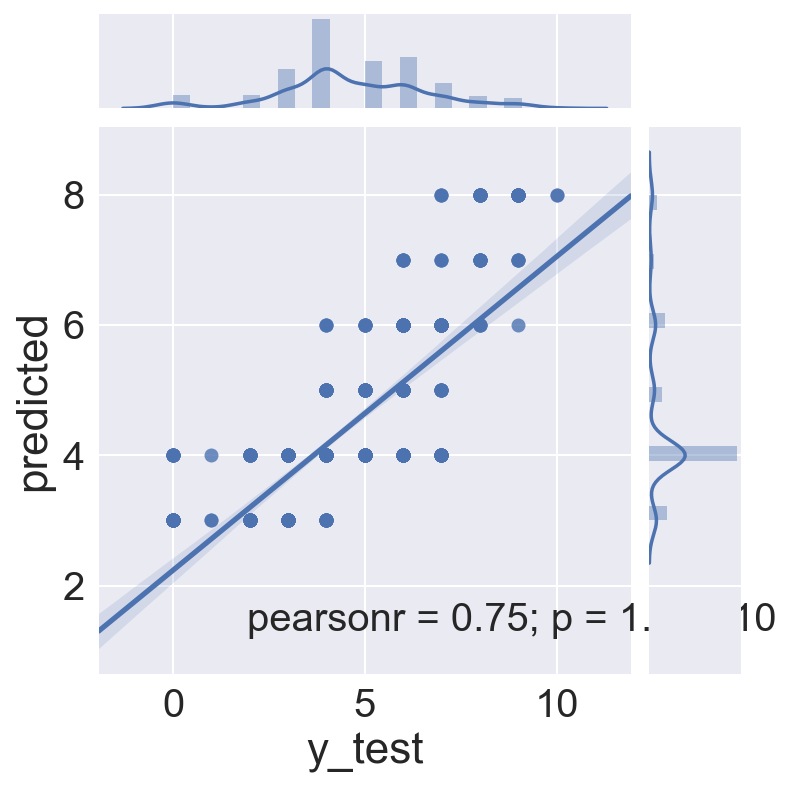

In [96]:
sns.jointplot(x='y_test', y='predicted', data=gs_logreg_test_m1, kind="reg")

## Run group of classifiers to find best performing model

The next step is to determine of other classifiers can produce a better model than logistic regression.  I used a method described by Jason Brownlee, https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/, to compare classifiers.

In this case, the Random Forrest classifier produced the highest score on the test data as well as on the cross validation of the training data. 


In [97]:
# Run lots of classifiers on this and see which perform the best
# Import all the modeling libraries

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
                                    KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt


Model:  Features    Train Set Accuracy    CrossVal Accuracy     Test Set Accuracy   
LR        5         0.409               0.406 +/- 0.005         0.395 
LDA       5         0.457               0.412 +/- 0.006         0.416 
QDA       5         0.004               0.007 +/- 0.001         0.003 
KNN       5         0.776               0.570 +/- 0.020         0.650 
CART      5         0.999               0.745 +/- 0.022         0.778 
RFST      5         0.988               0.747 +/- 0.027         0.784 
GB        5         0.903               0.733 +/- 0.025         0.779 
ADA       5         0.410               0.405 +/- 0.022         0.362 
SVM       5         0.505               0.494 +/- 0.015         0.436 
GNB       5         0.155               0.149 +/- 0.005         0.134 
    MNB  :   failed on this input dataset 
BNB       5         0.351               0.336 +/- 0.012         0.322 



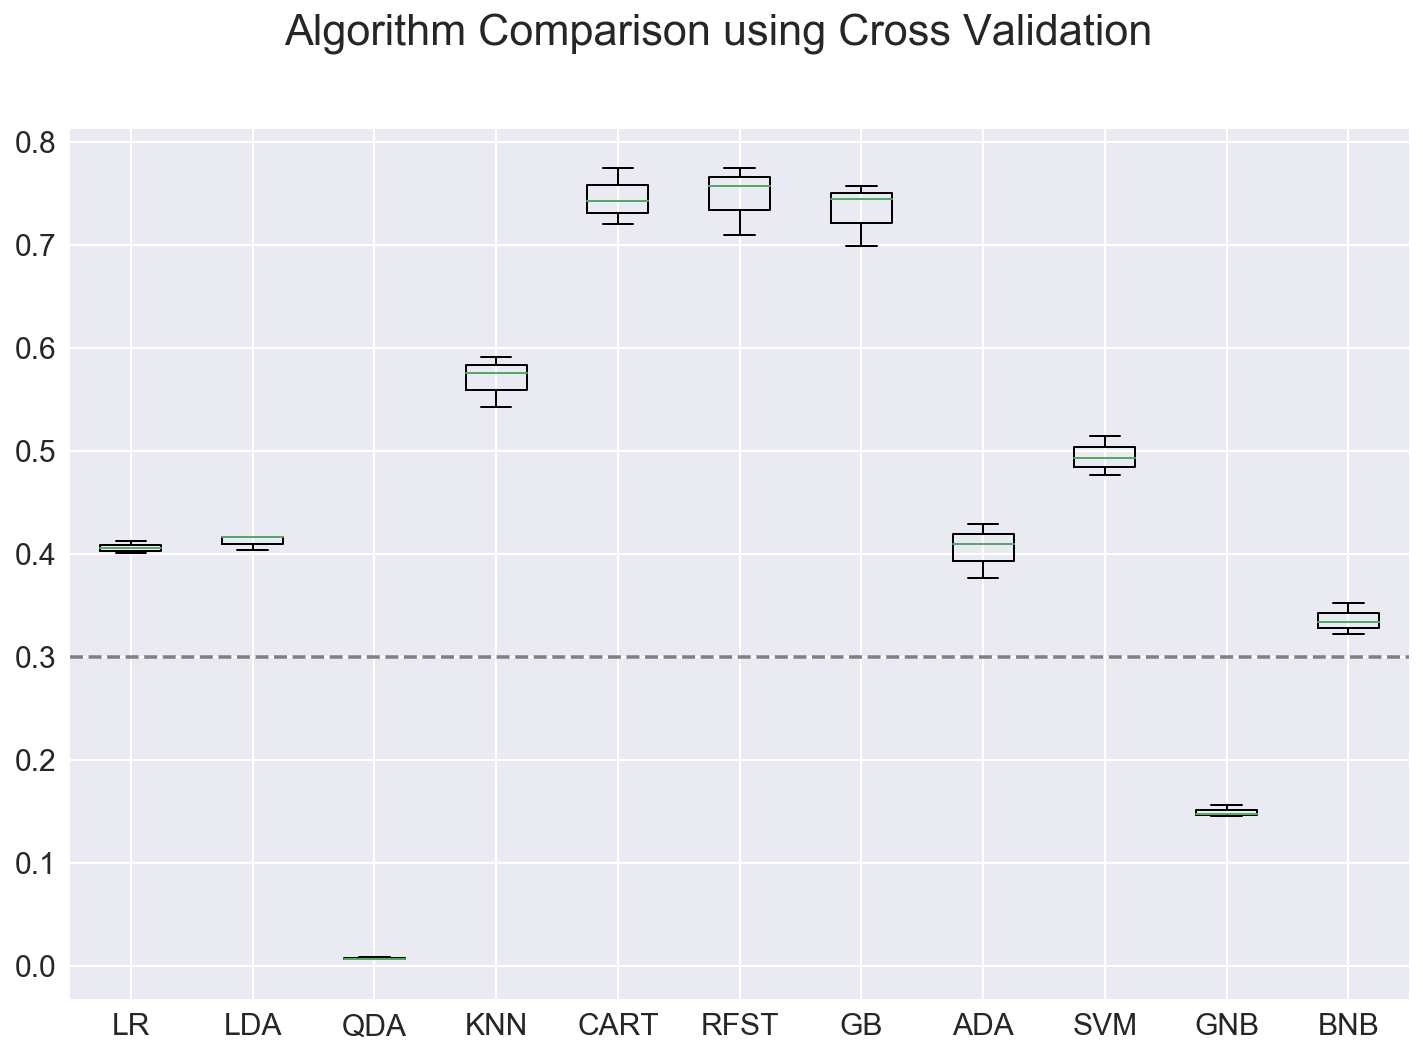

In [99]:
# prepare configuration for cross validation test harness
seed = 42

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFST', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SVM', SVC()))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

# print "\n{}:   {:0.3} ".format('Baseline', baseline, cv_results.std())
print "\n{:5.5}:  {:10.8}  {:20.18}  {:20.17}  {:20.17}".format\
        ("Model", "Features", "Train Set Accuracy", "CrossVal Accuracy", "Test Set Accuracy")

for name, model in models:
    try:
        kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, Xs_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        this_model = model
        this_model.fit(Xs_train,y_train)
        print "{:5.5}     {:}         {:0.3f}               {:0.3f} +/- {:0.3f}         {:0.3f} ".format\
                (name, Xs_train.shape[1], metrics.accuracy_score(y_train, this_model.predict(Xs_train)), \
                 cv_results.mean(), cv_results.std(), metrics.accuracy_score(y_test, this_model.predict(Xs_test)))
    except:
        print "    {:5.5}:   {} ".format(name, 'failed on this input dataset')

        
                
# boxplot algorithm comparison

# Set colors, as this shows up better on the grey back ground
# need to figure out how to set these colors for matplotlib boxplot
# from this color=color param that works for pandas boxplots
color = dict(boxes='DarkGreen', whiskers='DarkOrange', \
                medians='DarkBlue', caps='Gray')

print
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison using Cross Validation')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.axhline(y=baseline, color='grey', linestyle='--')
plt.show()

#### Decision Tree Graph

I ran a decision tree classifier simply to create a graph to help explain how decision trees work.  This one is useful as it shows how the various factors were used in different branches to maximize purity.

In [100]:
### Run a Decision Tree to produce an example visualization 
from sklearn.tree import DecisionTreeRegressor

dtrN = DecisionTreeRegressor(max_depth=3)
dtrN.fit(X_train, y_train)
dtrN_scores = cross_val_score(dtrN, X_train, y_train, cv=4)

print dtrN_scores, np.mean(dtrN_scores)

[ 0.61398968  0.59913131  0.60118508  0.63269497] 0.611750258258


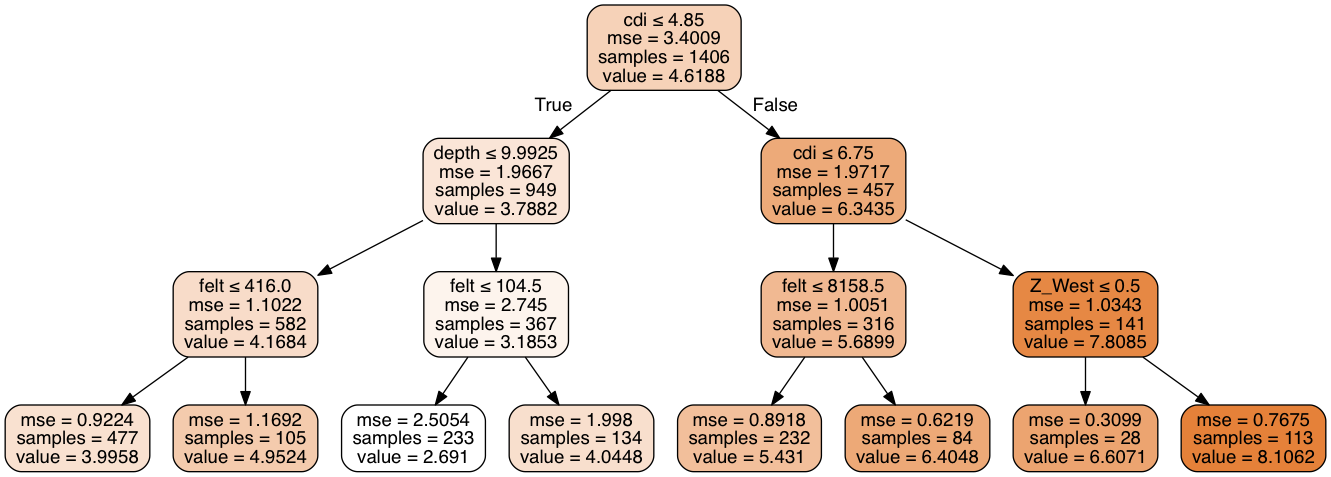

In [101]:
# feature_names = X.columns

# TEMPLATE CODE
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtr1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtrN, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

### Random Forest Classifier
The Random Forest is run again, this time to save the model and use it to predict the test set.  This is necessary because in the classifier loop above, the individual models are not saved.  Random Forest classification is non-deterministic unless a random state is fixed, which it was not in this case.  This run produce an even higher accuracy score of 0.803 on the test data.   

The plot shows the actual MMI intensities against the predicted MMI intensity for each quake in the test data set.  The Pearson correlation on this is 0.93, but there is still some spread in mid range intensity values, i.e. the prediction works better for higher intensity quakes.

In [102]:
# Re-run the Random Forrest model and use to predict MMI
# Save residuals for future model using additional factors

print "Random Forest Classifier using , factors:", list(X_train.columns)

rf = RandomForestClassifier()
rf.fit(Xs_train,y_train)

print "{:14.14}     {:}         {:0.3f}               {:0.3f} +/- {:0.3f}         {:0.3f} ".format\
                ('Random Forest', Xs_train.shape[1], metrics.accuracy_score(y_train, rf.predict(Xs_train)), \
                 cv_results.mean(), cv_results.std(), metrics.accuracy_score(y_test, rf.predict(Xs_test)))
        

Random Forest Classifier using factors: ['cdi', 'depth', 'felt', 'Z_East', 'Z_West']
Random Forest      5         0.989               0.336 +/- 0.012         0.803 


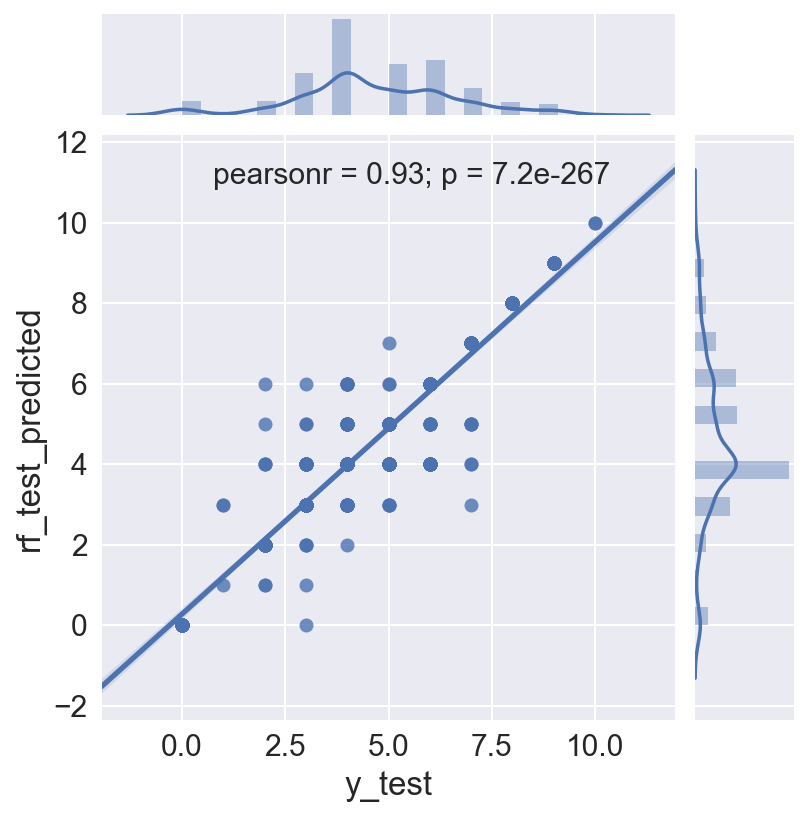

In [103]:
rf_test_predicted = rf.predict(Xs_test)
rf_train_predicted = rf.predict(Xs_train)
rf_test_residuals = y_test - rf_test_predicted
rf_train_residuals = y_train - rf_train_predicted

rf_test = pd.DataFrame({'y_test':y_test, 'rf_test_predicted':rf_test_predicted, 'rf_test_residuals':rf_test_residuals})
rf_train = pd.DataFrame({'y_train':y_train, 'rf_train_predicted':rf_train_predicted, \
                        'rf_train_residuals':rf_train_residuals})

rf_test = rf_test[['y_test', 'rf_test_predicted', 'rf_test_residuals']]
rf_train = rf_train[['y_train', 'rf_train_predicted', 'rf_train_residuals']]

sns.set(font_scale=1.5)
sns.jointplot(x='y_test', y='rf_test_predicted', data=rf_test, kind="reg")

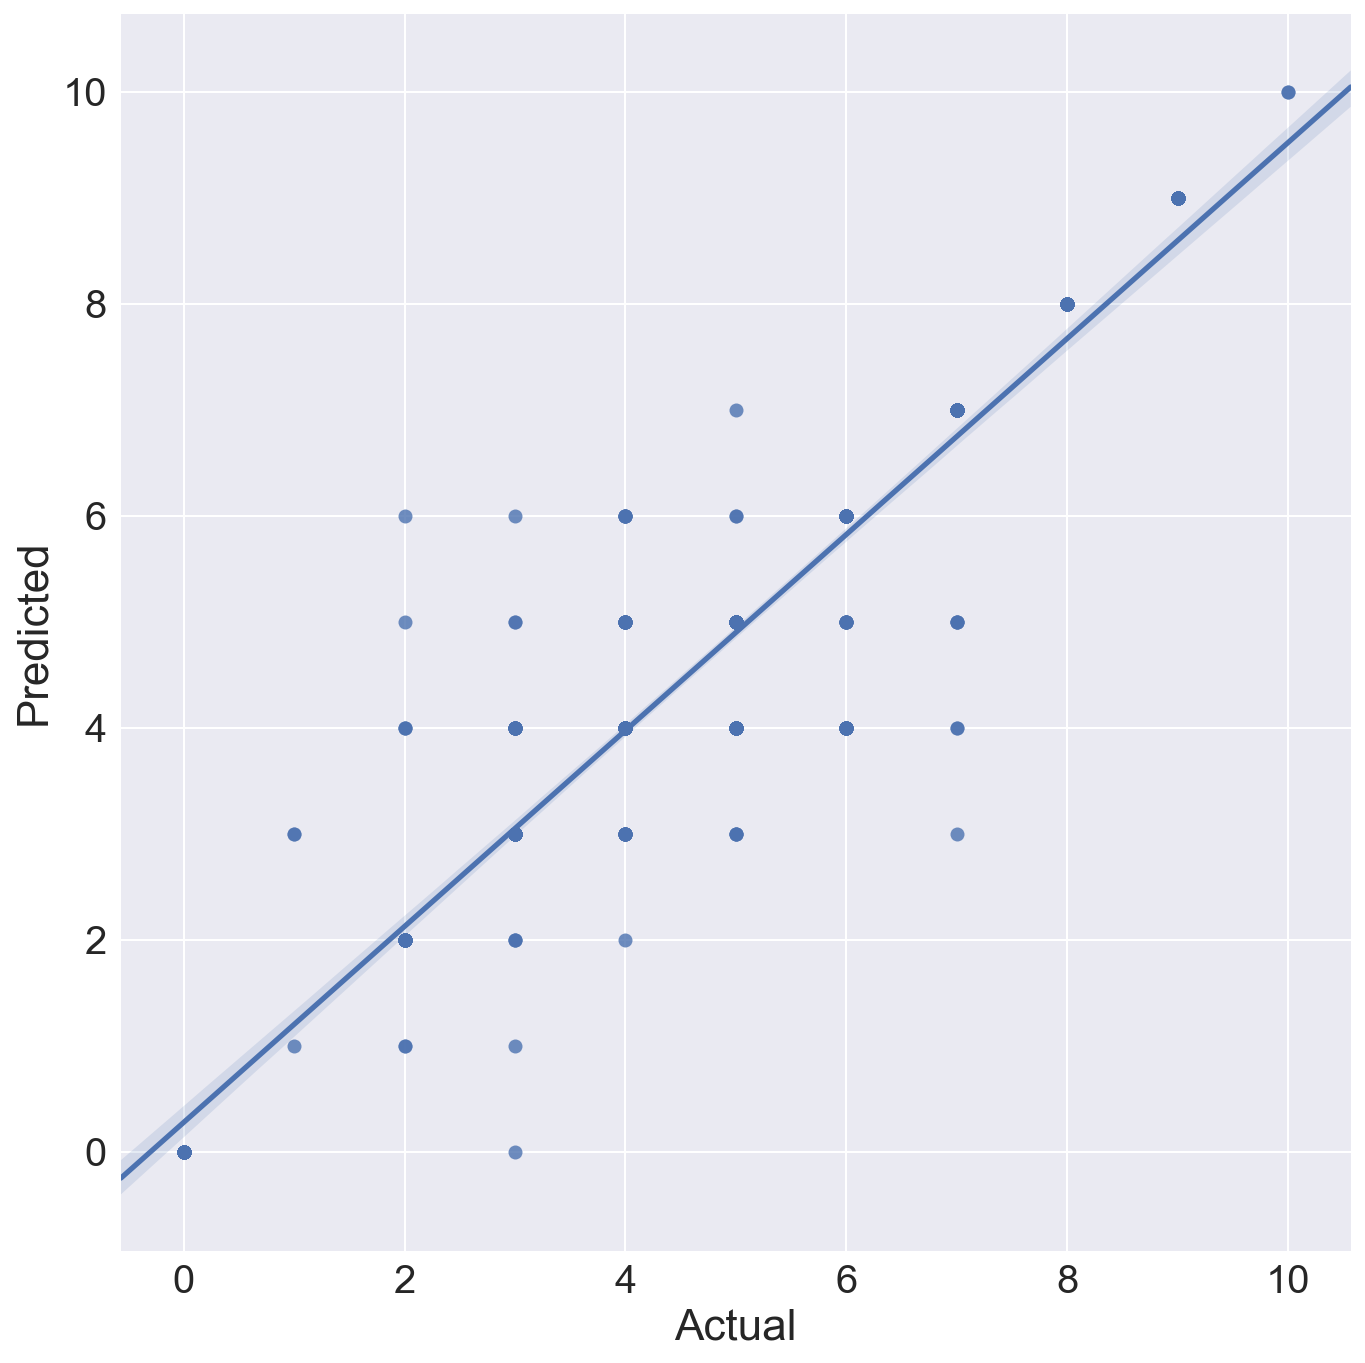

In [104]:
sns.set(font_scale=2)
rf_test_rename = rf_test.copy()
rf_test_rename.columns = ['Actual', 'Predicted', 'Residual']
sns.lmplot(x='Actual', y='Predicted', data=rf_test_rename, size=10, aspect=1)

### Gridsearch of Random Forest model to find best parameters

A grid search to determine the best parameters for:
  - number of trees
  - type of purity calculation
  - max depth of trees
  
was run.  It found that the gini impurity with a max depth of 12 and 30 trees was the best in the search, but the accuracy score was slightly lower.  The gridsearch did not, in this case, result in a better model, and plots of actual vs. predicted are substantially the same as the non-gridsearched model above.

In [106]:
# Gridsearch on Random Forest to find best depth
from sklearn.model_selection import GridSearchCV

# Gridsearch for best C and penalty
rfgs_params = {
    'n_estimators':[10,30,50],
    'criterion':['gini', 'entropy'],
    'max_depth':[4, 7, 12,None]
    }

# Define the GridSearch with CrossValidation and fit the model
rf_gridsearch = GridSearchCV(RandomForestClassifier(), rfgs_params, cv=3, verbose=1, n_jobs=-1)
rf_gridsearch.fit(Xs_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 30, 50], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 7, 12, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [107]:
# best score on the training data:
rf_gridsearch.best_score_

0.75248933143669983

In [108]:
# best parameters on the training data:
rf_gridsearch.best_params_

{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 30}

In [109]:
# assign the best estimator to a variable:
best_rf = rf_gridsearch.best_estimator_

In [110]:
# Score it on the testing data:
best_rf.score(Xs_test, y_test)

0.78275290215588722

In [111]:
# predict on the test data
rf_predicted = best_rf.predict(Xs_test)
rf_residuals = y_test - rf_predicted

In [112]:
# predict on test (for results) and train (for residuals for future model) data
gsrf_test_predicted = rf.predict(Xs_test)
gsrf_train_predicted = rf.predict(Xs_train)
gsrf_test_residuals = y_test - gsrf_test_predicted
gsrf_train_residuals = y_train - gsrf_train_predicted


gsrf_test_results = pd.DataFrame({'y_test':y_test, 'rf_predicted':gsrf_test_predicted, 'rf_residuals':gsrf_test_residuals})
gsrf_train_res = pd.DataFrame({'y_train':y_train, 'gsrf_train_predicted':rf_train_predicted, \
                        'rf_train_residuals':gsrf_train_residuals})


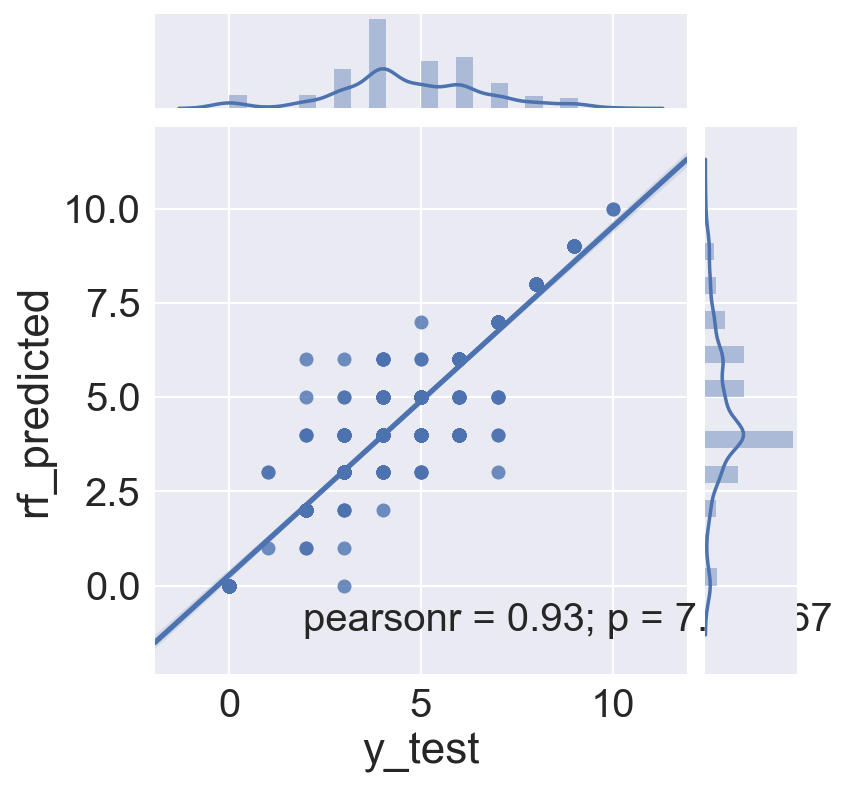

In [113]:
sns.jointplot(x='y_test', y='rf_predicted', data=gsrf_test_results, kind="reg")

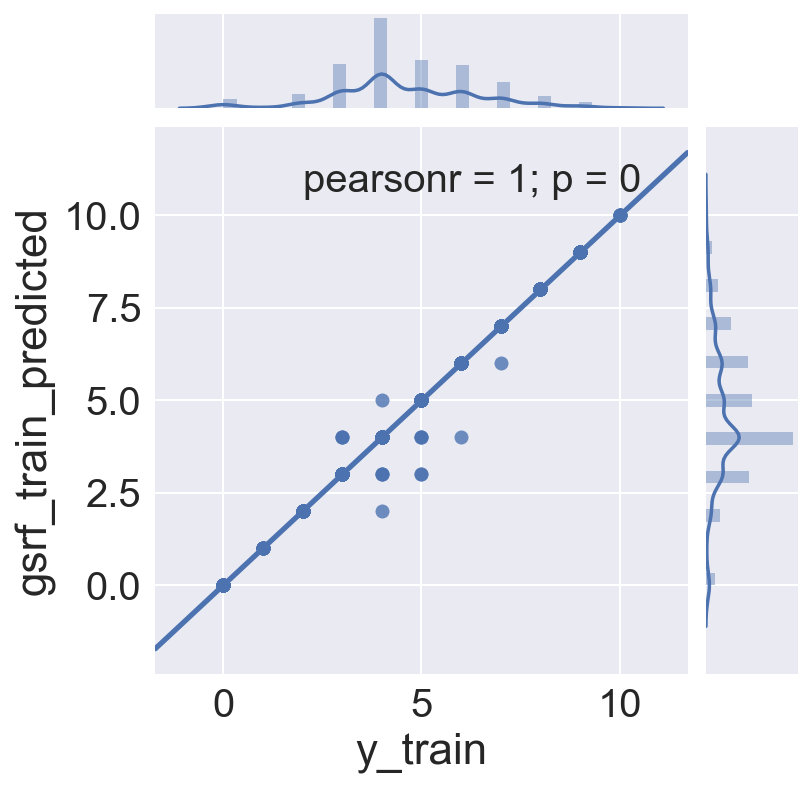

In [114]:
sns.jointplot(x='y_train', y='gsrf_train_predicted', data=gsrf_train_res, kind="reg")

In [115]:
# Seems there isn't much residual on the training set left to fit! 
print gsrf_train_res['rf_train_residuals'].abs().sum()
print len(gsrf_train_res['rf_train_residuals'])

19
1406


##  Include additional Features 

At this point I included additional features to attempt to product a better model.   The crustal features are from a model produced at Lawrence Livermore National Lab by Gabi Laske, Zhitu Ma, Guy Masters and Michael Pasyanos. https://igppweb.ucsd.edu/~gabi/crust1.html  Compressional and Shear wave arrivals from world wide seismic activity were used to determine the thickness and density of 3 crystalline and 3 sedimentary layers of crust at 1 degree intevals (latitude and longitude) WW, or at 64,800 (360 x 180) locations.   The data from the location closest to the earthquake epicenter was added for each quake. 

 - Crustal Features (Depth to Moho, Densities of crustal layers):   _The crustal features are from a model produced at Lawrence Livermore National Lab by Gabi Laske, Zhitu Ma, Guy Masters and Michael Pasyanos. https://igppweb.ucsd.edu/~gabi/crust1.html  Compressional and Shear wave arrivals from world wide seismic activity were used to determine the thickness and density of 3 crystalline and 3 sedimentary layers of crust at 1 degree intevals (latitude and longitude) WW, or at 64,800 (360 x 180) locations.   The data from the location closest to the earthquake epicenter was added for each quake. _
   
   
 - Reporting Station (net):   _The primary source, or reporting station, of the earthqauke information_
   
  
 - Magnitude Calculation Type (type)  _The type of calculation used to determin magnitude, which is dependent on the distance of the earthquake from the recording station_
   
   
 - Largest Azimuthal Gap (gap):  _The largest angle between recording stations,  larger angles reduce the accuracy of location and depth calculations._  
 
 
 - Number of stations reporting P and S arrival times (nst):  _Number of stations used to determine earthquake location._  
 
 
 - Earthquake Time of Day: _The hour of the day when earthquake occurred.  This was included to see if people reported intensity effects differently if they were awakend from sleep, or out and about at midday.  However, while the hour of day did show up as factor after regularization, no coherent pattern was able to be seen.   This model needs to be repeated without the hours included.   
   
   
  - Number of DYFI reports (felt):  _Total number of crowd sourced intensity reports available for each quake. Higher numbers of reprots will likely result in better accuracy when aggregated._

In [116]:
dfmw.head()

,alert,cdi,depth,felt,gap,id,lat,long,mag,magDecade,...,time,type,year,color,mmi-cdi_difference,mmi_round,cdi_round,diff_rounded,Z_East,Z_West
0,0.0,8.9,8.950,1141.0,123.4,ci3347678,34.416000,-118.370000,6.6,6.0,...,1971-02-09 09:00:41.920,earthquake,1971.0,FFFF00,-0.3,9,9,0,0,1
1,0.0,8.3,15.000,75.0,168.0,ci3352060,32.667333,-115.359167,6.4,6.0,...,1979-10-15 19:16:53.910,earthquake,1979.0,FFFF00,1.2,10,8,2,0,1
2,0.0,8.4,9.578,73.0,137.0,nc1091100,36.231667,-120.312000,6.7,6.0,...,1983-05-02 19:42:38.060,earthquake,1983.0,FFFF00,-0.1,8,8,0,0,1
3,0.0,6.8,17.214,2.0,89.0,nc216859,37.036167,-121.879833,6.9,6.0,...,1989-10-17 20:04:15.190,earthquake,1989.0,FFFF00,1.8,9,7,2,0,1
4,0.0,8.6,8.881,859.0,44.4,ci731691,34.061000,-118.079000,5.9,5.0,...,1987-10-01 10:42:20.020,earthquake,1987.0,80E100,-1.1,8,9,-1,0,1


In [117]:
def get_hour(timestr):
    timesplit = timestr.split()[1]
    hourstr = timesplit.split(":")[0]
    return hourstr

dfmw['tod_hour'] = dfmw['time'].map(lambda x: x.split()[1].split(":")[0])



In [118]:
# Dummy the hour of quake occurrence - for example, are dyfi reports different if quakes happen in night hours
dfmw = pd.get_dummies(dfmw, columns=['tod_hour'], prefix='H', prefix_sep='_')
dfmw = dfmw.drop('H_23', 1)


In [119]:
# Dummy the seismographic network
dfmw = pd.get_dummies(dfmw, columns=['net'], prefix='N', prefix_sep='_')
dfmw = dfmw.drop('N_us', 1)


In [120]:
dfmw.head()

,alert,cdi,depth,felt,gap,id,lat,long,mag,magDecade,...,H_22,N_ci,N_ld,N_mb,N_nc,N_nm,N_nn,N_se,N_uu,N_uw
0,0.0,8.9,8.950,1141.0,123.4,ci3347678,34.416000,-118.370000,6.6,6.0,...,0,1,0,0,0,0,0,0,0,0
1,0.0,8.3,15.000,75.0,168.0,ci3352060,32.667333,-115.359167,6.4,6.0,...,0,1,0,0,0,0,0,0,0,0
2,0.0,8.4,9.578,73.0,137.0,nc1091100,36.231667,-120.312000,6.7,6.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,6.8,17.214,2.0,89.0,nc216859,37.036167,-121.879833,6.9,6.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,8.6,8.881,859.0,44.4,ci731691,34.061000,-118.079000,5.9,5.0,...,0,1,0,0,0,0,0,0,0,0


In [121]:
# Add crustal thickness and density data from CRUST1.0
# Laske, G., Masters., G., Ma, Z. and Pasyanos, M., Update on CRUST1.0 - A 1-degree Global Model of Earth's Crust, 
# Geophys. Res. Abstracts, 15, Abstract EGU2013-2658, 2013.

rho = pd.read_csv('/Users/erhepp/fortran/crust1.0/crust1.rho', delim_whitespace=True, header=None, \
                 names=['top_water', 'bottom_water', 'bottom_ice', 'bottom_sed1', 'bottom_sed2', 'bottom_sed3', \
                       'bottom_crust1', 'bottom_crust2', 'bottom_crust3'])

bnds = pd.read_csv('/Users/erhepp/fortran/crust1.0/crust1.bnds', delim_whitespace=True, header=None, \
                 names=['top_water', 'bottom_water', 'bottom_ice', 'bottom_sed1', 'bottom_sed2', 'bottom_sed3', \
                       'bottom_crust1', 'bottom_crust2', 'bottom_crust3'])

print rho.shape, bnds.shape

def get_crust (qlat, qlong, crust_param):
# Return crustal density and thickness data for a given latitude / longitude
# When called with crust_param = 'rho'  returns lat, long and 9 values, 0-2 are surface water and ice, 
#    3-5 are sedimentary layer densities, and 6-8 are crystalline crust densities 
# When called with crust_param = 'bnds' the last value in list depth to the Mohorovičić discontinuity,
#    the boundary between the Earth's crust and mantle.


    # Prevent any float representation uncertainty from pushing latitude and longitude out of range
    if qlat >= 89.999: qlat = 89.999
    if qlat <= -89.999: qlat = -89.999
    if qlong >= 179.999: qlong = 179.999    
    if qlong <= -179.999: qlong = -179.999 
    
    # Find the closest crust1.0 grid locatio to the requested latitude and longitude
    if qlat >= 0:
        rlat = round(qlat - 0.5) + 0.5
    else:
        rlat = round(qlat + 0.5) - 0.5
   
    if qlong >= 0:
        rlong = round(qlong - 0.5) + 0.5
    else:
        rlong = round(qlong + 0.5) - 0.5

    # Determine the index in the crust1.0 files that corresponds to the closest grid location  
    # Information from the crust1.0 readme file
    #   The model is defined from 89.5 to -89.5 deg latitude and -179.5 to 179.5 deg
    #   longitude. Longitudes are the inner loop, i.e. all longitudes are stored
    #   for each latitude, then the next latitude is given. The model starts at
    #   89.5 N and 179.5 W.
    
    dist_from_north = 89.5 - rlat
    dist_from_west = 179.5 + rlong
    idx = int((dist_from_north)*360 + dist_from_west)
    
    # Calculate the latitude and longitude of the crust1.0 datapoint, and return the index loacation
    # latitude, longitude and, for each crustal layer, the density data.
    # Information from the crust1.0 readme file on order and meaning of values
    #    1) top of water
    #    2) bottom of water
    #    3) bottom of ice
    #    4) bottom of sediments 1
    #    5) bottom of sediments 2
    #    6) bottom of sediments 3
    #    7) bottom of cryst. crust 1
    #    8) bottom of cryst. crust 2
    #    9) bottom of cryst. crust 3 = Moho (depth to Moho, not crustal thickness!)

    # For this project, we will only use the density values for sediment and crystalline crust layers
    
    flat = 90 - dist_from_north-0.5
    flon = -180. + dist_from_west+0.5
    if crust_param == 'rho':
        return [idx, flat, flon, round(rho.iloc[idx,0],2), round(rho.iloc[idx,1],2), \
                                             round(rho.iloc[idx,2],2), round(rho.iloc[idx,3],2), \
                                             round(rho.iloc[idx,4],2), round(rho.iloc[idx,5],2), \
                                             round(rho.iloc[idx,6],2), round(rho.iloc[idx,7],2), \
                                             round(rho.iloc[idx,8],2)]
    if crust_param == 'bnds':
        return [idx, flat, flon, round(rho.iloc[idx,0],2), round(bnds.iloc[idx,1],2), \
                                             round(bnds.iloc[idx,2],2), round(bnds.iloc[idx,3],2), \
                                             round(bnds.iloc[idx,4],2), round(bnds.iloc[idx,5],2), \
                                             round(bnds.iloc[idx,6],2), round(bnds.iloc[idx,7],2), \
                                             round(bnds.iloc[idx,8],2)]



(64800, 9) (64800, 9)


In [122]:
dfmw.shape

(2009, 53)

In [123]:
for idx in range(len(dfmw)):
    dfmw.loc[idx, 'crust_thickness'] = np.abs(get_crust(dfmw.loc[idx, 'lat'], dfmw.loc[idx, 'long'], 'bnds')[-1])
    dfmw.loc[idx, 'sed_density1'] = get_crust(dfmw.loc[idx, 'lat'], dfmw.loc[idx, 'long'], 'rho')[6]
    dfmw.loc[idx, 'sed_density2'] = get_crust(dfmw.loc[idx, 'lat'], dfmw.loc[idx, 'long'], 'rho')[7]
    dfmw.loc[idx, 'sed_density3'] = get_crust(dfmw.loc[idx, 'lat'], dfmw.loc[idx, 'long'], 'rho')[8]
    dfmw.loc[idx, 'cryst_crust1_density'] = get_crust(dfmw.loc[idx, 'lat'], dfmw.loc[idx, 'long'], 'rho')[9]
    dfmw.loc[idx, 'cryst_crust2_density'] = get_crust(dfmw.loc[idx, 'lat'], dfmw.loc[idx, 'long'], 'rho')[10]
    dfmw.loc[idx, 'cryst_crust3_density'] = get_crust(dfmw.loc[idx, 'lat'], dfmw.loc[idx, 'long'], 'rho')[11]

print dfmw.shape
dfmw.head()
    


(2009, 60)


,alert,cdi,depth,felt,gap,id,lat,long,mag,magDecade,...,N_se,N_uu,N_uw,crust_thickness,sed_density1,sed_density2,sed_density3,cryst_crust1_density,cryst_crust2_density,cryst_crust3_density
0,0.0,8.9,8.950,1141.0,123.4,ci3347678,34.416000,-118.370000,6.6,6.0,...,0,0,0,29.37,2.28,0.0,2.79,2.86,2.95,3.30
1,0.0,8.3,15.000,75.0,168.0,ci3352060,32.667333,-115.359167,6.4,6.0,...,0,0,0,25.44,2.28,0.0,2.74,2.78,2.86,3.32
2,0.0,8.4,9.578,73.0,137.0,nc1091100,36.231667,-120.312000,6.7,6.0,...,0,0,0,25.91,2.28,0.0,2.79,2.86,2.95,3.29
3,0.0,6.8,17.214,2.0,89.0,nc216859,37.036167,-121.879833,6.9,6.0,...,0,0,0,25.30,2.28,0.0,2.79,2.86,2.95,3.30
4,0.0,8.6,8.881,859.0,44.4,ci731691,34.061000,-118.079000,5.9,5.0,...,0,0,0,29.37,2.28,0.0,2.79,2.86,2.95,3.30


In [124]:
factors = [x for x in dfmw.columns if x not in ['alert', 'id', 'lat', 'long', 'magDecade', 'time', 'year', 'color', \
                                                'mmi', 'mmi-cdi_difference', 'mmi_round', 'cdi_round', 'diff_rounded', \
                                                'type']]
print factors

ya = dfmw['mmi_round'].values
Xa = dfmw[factors]
# Modeled in prior model
# X = dfmw[['cdi', 'depth', 'felt', 'Z_East', 'Z_West']]

['cdi', 'depth', 'felt', 'gap', 'mag', 'Z_East', 'Z_West', 'H_00', 'H_01', 'H_02', 'H_03', 'H_04', 'H_05', 'H_06', 'H_07', 'H_08', 'H_09', 'H_10', 'H_11', 'H_12', 'H_13', 'H_14', 'H_15', 'H_16', 'H_17', 'H_18', 'H_19', 'H_20', 'H_21', 'H_22', 'N_ci', 'N_ld', 'N_mb', 'N_nc', 'N_nm', 'N_nn', 'N_se', 'N_uu', 'N_uw', 'crust_thickness', 'sed_density1', 'sed_density2', 'sed_density3', 'cryst_crust1_density', 'cryst_crust2_density', 'cryst_crust3_density']


In [125]:
Xa.head()

,cdi,depth,felt,gap,mag,Z_East,Z_West,H_00,H_01,H_02,...,N_se,N_uu,N_uw,crust_thickness,sed_density1,sed_density2,sed_density3,cryst_crust1_density,cryst_crust2_density,cryst_crust3_density
0,8.9,8.950,1141.0,123.4,6.6,0,1,0,0,0,...,0,0,0,29.37,2.28,0.0,2.79,2.86,2.95,3.30
1,8.3,15.000,75.0,168.0,6.4,0,1,0,0,0,...,0,0,0,25.44,2.28,0.0,2.74,2.78,2.86,3.32
2,8.4,9.578,73.0,137.0,6.7,0,1,0,0,0,...,0,0,0,25.91,2.28,0.0,2.79,2.86,2.95,3.29
3,6.8,17.214,2.0,89.0,6.9,0,1,0,0,0,...,0,0,0,25.30,2.28,0.0,2.79,2.86,2.95,3.30
4,8.6,8.881,859.0,44.4,5.9,0,1,0,0,0,...,0,0,0,29.37,2.28,0.0,2.79,2.86,2.95,3.30


In [126]:
# Train/Test Split 
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size=0.30, random_state=42)

In [127]:
# Standardize the data

ss = StandardScaler()
Xas_train = ss.fit_transform(Xa_train)
Xas_test = ss.transform(Xa_test)

In [128]:
# The first example uses SciKit Learn

# Logistic Regression instantiation.  Note that penalty and solver are set to the defaults.
# See http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for details

lr_all = LogisticRegression(penalty="l2", C=1, fit_intercept=True, solver="liblinear")


In [129]:
# fit the model
lr_all.fit(Xas_train, ya_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [143]:
# Review the results

# The score, intercept and coefficients 
print "Model Score (Train):", lr_all.score(Xas_train, ya_train)
print "\nModel Score (Test):",  lr_all.score(Xas_test, ya_test)
print "\nPrediction Classes:", lr_all.classes_

print "\nIntercept:", lr_all.intercept_
print "\nCoefficients:", lr_all.coef_



Model Score (Train): 0.663584637269

Model Score (Test): 0.620232172471

Prediction Classes: [ 0  1  2  3  4  5  6  7  8  9 10]

Intercept: [-5.75596323 -5.74830708 -5.53650979 -3.39372938 -1.38765705 -2.17328594
 -3.01130824 -4.93942256 -6.78984715 -6.47045241 -5.84615273]

Coefficients: [[ -2.58341801e-01   1.91478856e-01  -2.29945447e-01  -2.45489423e-01
    4.37757223e-01   2.21934589e-02   1.54707869e-01  -1.87088332e-01
   -5.35097681e-01  -2.75771698e-01  -3.60223784e-01  -7.81297490e-02
    1.42051173e-01  -2.39415523e-01  -4.03669183e-01  -2.96791777e-01
   -9.01655126e-01  -8.42585622e-02  -2.04741127e-01  -6.74128957e-01
   -3.59423019e-01  -1.49681086e-01  -8.57339498e-02  -5.85560246e-02
   -2.60128290e-01  -9.39246750e-02  -1.84595102e-01  -2.06227241e-01
   -7.65406963e-02  -6.22977405e-01  -2.53368720e-01   2.03628579e-01
   -1.81248265e-02  -7.66957985e-01  -3.38863343e-02  -1.78920149e-01
    4.17059890e-02  -3.27152934e-02  -1.87850642e-01  -9.83190861e-02
    1.2906

In [144]:
# Get predicted values to plot against actuals
all_predicted = lr_all.predict(Xas_test)


In [145]:
logreg_test = pd.DataFrame({'ya_test' : ya_test, 'predicted' : all_predicted})
logreg_test = logreg_test[['ya_test', 'predicted']]

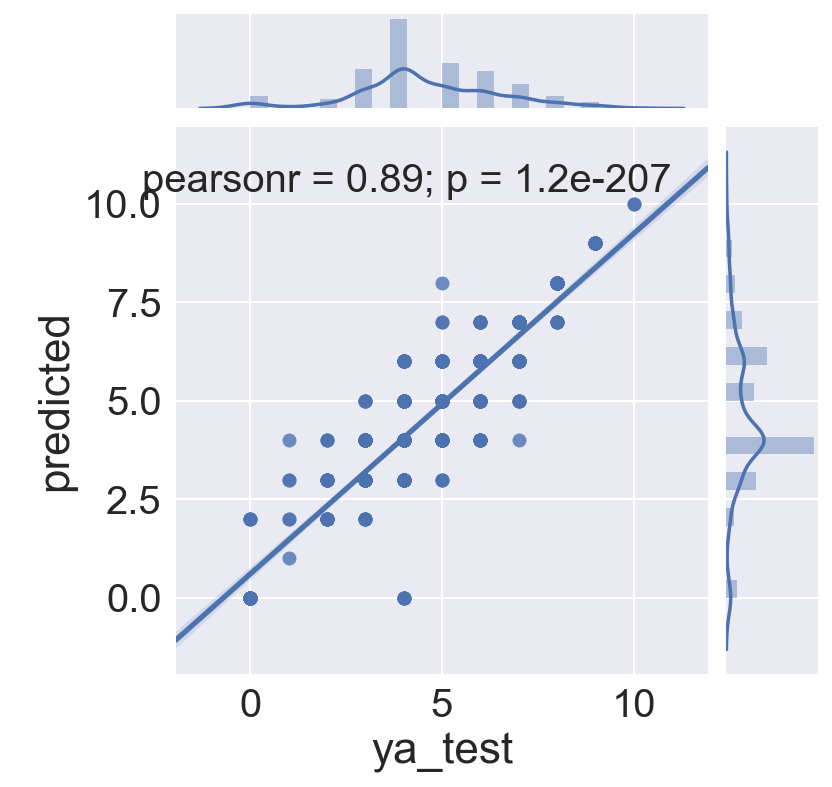

In [146]:
sns.jointplot(x='ya_test', y='predicted', data=logreg_test, kind="reg")

In [175]:
logreg_test.head()

,ya_test,predicted
0,4,4
1,4,4
2,6,4
3,5,6
4,4,4


### Set up for GridSearch and try again, determine if the model be further improved.

In [176]:
from sklearn.model_selection import GridSearchCV

# Gridsearch for best C and penalty
gs_params = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,5,100)
}

# Define the GridSearch with CrossValidation and fit the model
lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=3, verbose=1, n_jobs=-1)
lr_gridsearch.fit(Xas_train, ya_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.26186e-05, ...,   7.92483e+04,   1.00000e+05]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [177]:
# best score on the training data:
lr_gridsearch.best_score_

0.67638691322901845

In [178]:
# best parameters on the training data:
lr_gridsearch.best_params_

{'C': 14.508287784959402, 'penalty': 'l1', 'solver': 'liblinear'}

In [179]:
# assign the best estimator to a variable:
best_lr = lr_gridsearch.best_estimator_

In [180]:
# Score it on the testing data:
best_lr.score(Xas_test, ya_test)

0.67495854063018246

In [191]:
# Get predicted values to plot against actuals
gsall_predicted = best_lr.predict(Xas_test)


In [193]:
gs_logreg_test = pd.DataFrame({'ya_test' : ya_test, 'predicted' : gsall_predicted})
gs_logreg_test = logreg_test[['ya_test', 'predicted']]

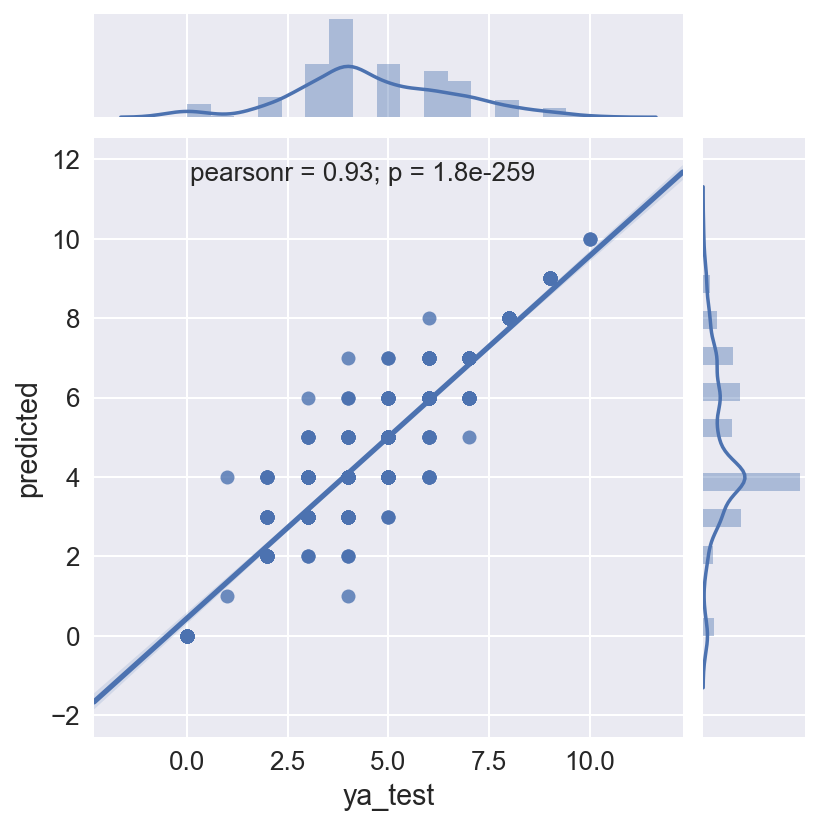

In [194]:
sns.jointplot(x='ya_test', y='predicted', data=gs_logreg_test, kind="reg")

In [195]:
print len(Xa.columns), len(best_lr.coef_[0]), len(np.round(np.exp(best_lr.coef_[0])*100-100,2))

46 46 46


In [196]:
coef_df = pd.DataFrame({
        'features': Xa.columns,
        'log odds': best_lr.coef_[0],
        'percentage change in odds': np.round(np.exp(best_lr.coef_[0])*100-100,2)
    })

In [197]:
coef_df.sort_values(by='percentage change in odds', ascending=0)

,features,log odds,percentage change in odds
4,mag,3.320124,2666.38
1,depth,1.441819,322.84
3,gap,0.639691,89.59
0,cdi,0.000000,0.00
28,H_05,0.000000,0.00
20,cryst_crust1_density,0.000000,0.00
21,cryst_crust2_density,0.000000,0.00
22,cryst_crust3_density,0.000000,0.00
27,H_04,0.000000,0.00
37,H_14,0.000000,0.00


In [198]:
# Create a subset of "coef_df" DataFrame with most important coefficients
imp_coefs = pd.concat([coef_df.sort_values(by='percentage change in odds', ascending=0).head(4),
                     coef_df.sort_values(by='percentage change in odds', ascending=0).tail(18)])

In [199]:
imp_coefs.set_index('features', inplace=True)
imp_coefs

,log odds,percentage change in odds
features,,
mag,3.320124,2666.38
depth,1.441819,322.84
gap,0.639691,89.59
cdi,0.000000,0.00
H_10,-0.060049,-5.83
H_19,-0.141052,-13.16
H_17,-0.351786,-29.66
N_uw,-0.511928,-40.07
H_03,-0.544275,-41.97


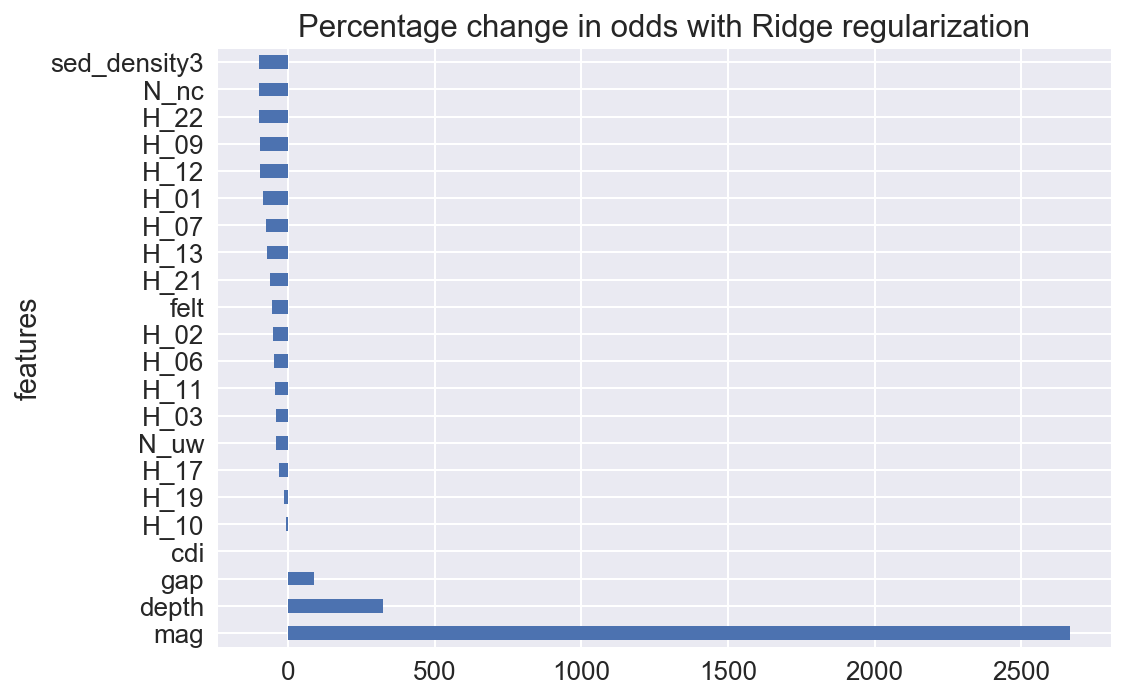

In [200]:
# Plot important coefficients
sns.set(font_scale=1.3)
imp_coefs['percentage change in odds'].plot(kind = "barh")
plt.title("Percentage change in odds with Ridge regularization")
plt.show()

## Comments

There is clearly some more investigation required.   The hour of day does seem to affect the model, but close examination reveals no coherent pattern, and this is likely overfitted, despite the closeness of the accuracy scores between the training and test datasets. 

The CDI, or crowd sourced intensity, is now no longer an important factor in predicting MMI, as the model shows magnitude and depth as the most significant predictors.   This is not surprising, as we have shown above that maximum CDI intensity seems to under report when compared with MMI.  

Stay tuned to this site for future updates, which I hope to complete soon.

## Again run group of classifiers to find best performing model

I ran the loop of different classifiers on the important coefficients determined from logistic regression with regularization.  This is questionble, as we shouldn't assume that the factors unimportant in one model will be unimportant in other models, but in this case, using the  can produce a better model than logistic regression.  I used a method described by Jason Brownlee, https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/, to compare classifiers.

In this case, the Random Forrest classifier produced the highest score on the test data as well as on the cross validation of the training data. 


In [201]:
# Get list of features and re-run model with just the 20 most important features
imp_features = imp_coefs.index

In [204]:
# Set up X and y
Xi = dfmw[factors]
yi = dfmw['mmi_round'].values


In [205]:
# Test Train Split

Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.30)

In [206]:
# Standardize 
ss = StandardScaler()

Xis_train = ss.fit_transform(Xi_train)
Xis_test = ss.transform(Xi_test)# Test Train Split



Model:  Features    Train Set Accuracy    CrossVal Accuracy     Test Set Accuracy   
LR        46         0.700               0.622 +/- 0.012         0.629 
LDA       46         0.701               0.626 +/- 0.024         0.657 
    QDA  :   failed on this input dataset 
KNN       46         0.807               0.633 +/- 0.041         0.708 
CART      46         1.000               0.805 +/- 0.004         0.806 
RFST      46         0.993               0.817 +/- 0.017         0.841 
GB        46         0.974               0.819 +/- 0.021         0.854 
ADA       46         0.415               0.416 +/- 0.041         0.413 
SVM       46         0.829               0.707 +/- 0.025         0.733 
GNB       46         0.230               0.225 +/- 0.013         0.222 
    MNB  :   failed on this input dataset 
BNB       46         0.556               0.509 +/- 0.022         0.529 


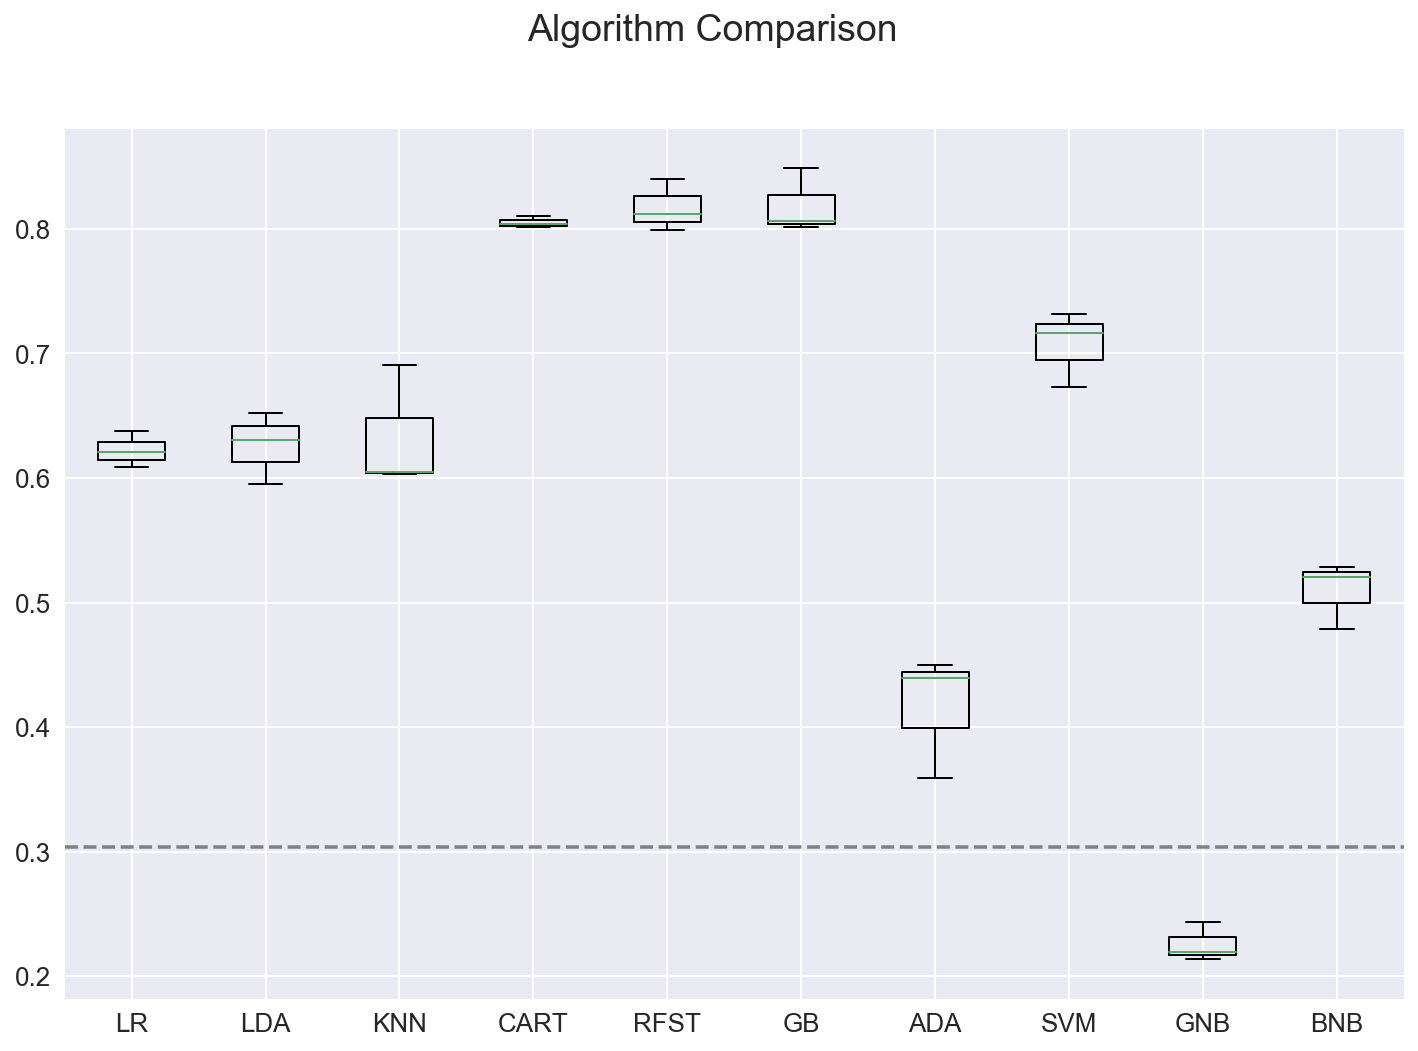

In [207]:
# prepare configuration for cross validation test harness
seed = 42

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFST', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SVM', SVC()))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

# print "\n{}:   {:0.3} ".format('Baseline', baseline, cv_results.std())
print "\n{:5.5}:  {:10.8}  {:20.18}  {:20.17}  {:20.17}".format\
        ("Model", "Features", "Train Set Accuracy", "CrossVal Accuracy", "Test Set Accuracy")

for name, model in models:
    try:
        kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, Xis_train, yi_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        this_model = model
        this_model.fit(Xis_train,yi_train)
        print "{:5.5}     {:}         {:0.3f}               {:0.3f} +/- {:0.3f}         {:0.3f} ".format\
                (name, Xis_train.shape[1], metrics.accuracy_score(yi_train, this_model.predict(Xis_train)), \
                 cv_results.mean(), cv_results.std(), metrics.accuracy_score(yi_test, this_model.predict(Xis_test)))
    except:
        print "    {:5.5}:   {} ".format(name, 'failed on this input dataset')

        
                
# boxplot algorithm comparison
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.axhline(y=baseline, color='grey', linestyle='--')
plt.show()